### **PROBLEM STATEMENT**
- Delhivery, India's leading logistics service provider, collect vast amounts of raw delivery trip data through its systems.
- Each delivery trip is logged with multiple segements
  - Like(Think of connecting legs in Journey ),
- Making it difficult to directly analyze or forecast delivery performance.

- Our Goal is to clean and create features in better engineer format from this data to help the data science team build forecasting models for time and efficiency.
 - Merging and aggregating trip data properly.
 - Extracting usefull features (Like time, distance, delay).
 - Handling missing data and outliers
 - Encoding and scaling data for models.
 - Uncovering Insights to improve business operations.


### **STAR METHOD**
**S-SITUATION**
- delhivery Logs delivery trips in segments, where each row represents part of a trip.
- The data is scattered across multiple fields and including missing values, outliers, and mixed format. This Fragmented data is challenging for analytics or modelling without prior transformation.

**T-TASK**
- Aggregate the trip based on trip_uuid to reflect the entire Journey of a delivery
- Create meaningfull features Like total time, Distance, delay, Route characteristics from raw data fields.
- Handle Missing values and outliers for accurate downstream analysis.
- Transform categorical and numerical fields
- Derive insights into delivery performance and suggest actionable insights.

**A-ACTION**
  - **DATA CLEANING:**
    - Detected and treated missing values. converted data types appropriately.
  - **AGGREGATION:**
    - Used grouby on trip_uuid to aggreagte time, distance, and other numeric fields.
  - **FEATURE ENGINEERING:**
    - Parsed trip_creation_time to get day, month, weekday
    - calculated trip using od_start_time and od_end_time
    - Extracted state and city from source_name and destination_name
    - Compared actual vs. expected times (OSRM and segment-based)
  - **OUTLIER TREATMENT:**
    - Detected with Boxplots, Handled using IQR Method.
  - **ENCODING & SCALING:**
    - Applied One-hot Encoding to route_type; standardized Numeric Features.
  - **VISUAL & HYPOTHESIS TESTING:**
    - Compared actual and Predicted times or distance across trips using plots and T-Tests

**R-RESULT:**
- Found that actual time and OSRM time significantly differed, suggesting prediction inaccuracies.
- Identified strong concentration of trips in Maharashtra (18.3%) and Mumbai (9.7%).
- Noted predictable customer demand mid-month and evenings.
- Confirmed statistically that some feature pairs (e.g. actual_time and osrm_time) do not align.
- Detected 1500+ outliers across several columns using IQR.
- Provided 12 strategic recommendations, including route improvement, OSRM calibration, and regional focus.

### **IMPORTING LIBRARIES**

In [1017]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **LOADING DATASET**

In [1019]:
import requests

# Step 1: File URL and desired name
url = 'https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181'
filename = 'Delivery.csv'

# Step 2: Send GET request and save the file
response = requests.get(url)
with open(filename, 'wb') as file:
    file.write(response.content)

print(f"✅ File downloaded and saved as '{filename}'")

✅ File downloaded and saved as 'Delivery.csv'


In [1020]:
import pandas as pd

df = pd.read_csv('Delivery.csv')

### **PREVIEW THE DATASET**

In [1022]:
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


### **TAIL OF THE DATASET**

In [1024]:
df.tail()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
144862,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,...,2018-09-20 21:57:20,45.258278,94.0,60.0,67.9280,1.566667,12.0,12.0,8.1858,1.000000
144863,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,...,2018-09-20 21:31:18,54.092531,120.0,76.0,85.6829,1.578947,26.0,21.0,17.3725,1.238095
144864,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,...,2018-09-20 21:11:18,66.163591,140.0,88.0,97.0933,1.590909,20.0,34.0,20.7053,0.588235
144865,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,...,2018-09-20 20:53:19,73.680667,158.0,98.0,111.2709,1.612245,17.0,27.0,18.8885,0.629630
144866,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,...,2018-09-20 16:24:28.436231,70.039010,426.0,95.0,88.7319,4.484211,268.0,9.0,8.8088,29.777778


### **DATASET**

In [1026]:
df.iloc[:, :12]

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...
144862,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0
144863,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0
144864,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0
144865,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0


In [1027]:
df.iloc[:, 12:]

,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,True,9,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,True,18,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,True,36,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,False,39,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
144862,True,45,2018-09-20 21:57:20,45.258278,94.0,60.0,67.9280,1.566667,12.0,12.0,8.1858,1.000000
144863,True,54,2018-09-20 21:31:18,54.092531,120.0,76.0,85.6829,1.578947,26.0,21.0,17.3725,1.238095
144864,True,63,2018-09-20 21:11:18,66.163591,140.0,88.0,97.0933,1.590909,20.0,34.0,20.7053,0.588235
144865,True,72,2018-09-20 20:53:19,73.680667,158.0,98.0,111.2709,1.612245,17.0,27.0,18.8885,0.629630


### **SHAPE OF THE DATA**

In [1029]:
df.shape

(144867, 24)

### **COLUMNS**

In [1031]:
df.columns

Index(['data', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'actual_time',
       'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time',
       'segment_osrm_time', 'segment_osrm_distance', 'segment_factor'],
      dtype='object')

### **DATA TYPES**

In [1033]:
df.dtypes

data                               object
trip_creation_time                 object
route_schedule_uuid                object
route_type                         object
trip_uuid                          object
source_center                      object
source_name                        object
destination_center                 object
destination_name                   object
od_start_time                      object
od_end_time                        object
start_scan_to_end_scan            float64
is_cutoff                            bool
cutoff_factor                       int64
cutoff_timestamp                   object
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
factor                            float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
segment_factor                    

### **DATASET INFO**

In [1035]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

# Observation:
- The dataset contains 1,44,867 delivery segment entries
- The dataset includes both trip-level and segment-level delivery information.
- Source name & Destination name has missing values.
- Columns like trip_creation_time, od_start_time, od_end_time and cutoff_timestamp are of type Object, These shouls be converted to datetime format.
- trip_uuid and route_schedule_uuid help in grouping trips or aggregating segments into full journeys.
- Delivery Time and Distance columns exist includes both actual and predicted (OSRM) Values
  - actual_time, osrm_time, segment_actual_time, segment_osrm_time, actual_distance_to_destination, osrm_distance, segment_osrm_distance
  - usefull for performance comparison and delay analysis.
- Each trip(trip_uuid) can have multiple rows to analyze full-trip Performance.

# Final Observation:
- Convert date/time columns to datetime format
- Fill missing values in source_name and destination_name
- Group data by trip_uuid for full-trip aggregation
- **CREATE FEATURES LIKE:**
  - Total Trip Time (od_end_time - od_start_time)
  - Day, Month, weekday From trip_creation_time.
  - Delay = actual_time - osrm_time
- Handle outliers in numeric columns using boxplots and IQR Method
- One-Hot encode route_type for Modelling.

# Observation:
- The dataset contains 144867 records and 24 features, The dataset belongs to delivery log entries of trips, Each row represents a trip.
- **DETAILED COLUMN DESCRIPTION AND FEATURE IMPORTANCE**
- **data:** Indicates whether the row belongs to training or testing. its just a tag.
- **trip_creation_time:** Timestamp when the trip was created, can be usefull for features like time of the day, day of the week, month, peak hours.
- **route_schedule_uuid:** Unique Identifier for a specific route scheduled, can be usefull for route-based grouping.
- **route_type:** Type of transport: FTL (Full Truck Load), carting, Important for understanding speed, efficiency, and delivery Expectations.
- **trip_uuid:** Unique ID for a trip, Important for aggreagtion and trip-level analysis.
- **Source_center:** ID of the Origin center, Can be used to Identifying top-Performing or delay Hubs.
- **Source_name:** Full name of the origin (Includes City, place Code, State), Useful for extracting city/state, which may influence delivery time or distance
- **Destination_center:** ID of destination center, similar use of source center.
- **Destination_name:** Full name of the destination (Includes City, Place code, state), can derive state-to-state patterns.
- **od_start_time:** Actual start time of delivery from the source, Needed for calculating durations.
- **od_end_time:** Actual end time at the destination, High required to compute trip duration.
- **start_scan_to_end_scan:** Time taken from the first scan to the final scan (Destination)
- **actual_distance_to_destination:** Real world distance between source and destination, crucial for route optimization, Planning, Delay analysis.
- **actual_time:** Total actual time taken to complete the delivery, Important for delivery efficiency.
- **osrm_time:** calculates the travel time and distance from a point of origin to a point of destination, Estimated time by Routing Engine based on distance and traffic conditions, Used for deviation analysis and planning optimization.
- **osrm_distance:** Estimated distance by OSRM Routing, Used for deviation analysis and planning optimization.
- **segment_actual_time:** Actual time taken for one segment of a full trip.
- **segment_osrm_time:** Estimated segment time (OSRM). used for comparison with segment_actual_time
- **segment_osrm_distance:** Estimated distance for a trip segment, usefull for segment-wise patterns.

# Top High-Performing Features For Analysis
  - **There are must use in delivery Performnace, efficiency, & EDA**
  -**trip_creation_time : Feature extraction like Hour, day, month**
  - **route_type : categorical impact on delivery speed.**
  - **source_name, destination_name : Extract city, state, pincode**
  - **od_start_time, od_end_time : Compute actual duration**
  - **start_scan_to_end_scan: scan based delivery time**
  - **actual_time, osrm_time, segment_actual_time : Performance comparison.**
  - **actual_distance_to_distance, osrm_distance : Distance Comparison**

### **ALL COLUMNS**

In [1041]:
df.columns

Index(['data', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'actual_time',
       'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time',
       'segment_osrm_time', 'segment_osrm_distance', 'segment_factor'],
      dtype='object')

### **DROPPING UNKNOWN COLUMNS**

In [1043]:
unknown_fields = ['is_cutoff', 'cutoff_factor', 'cutoff_timestamp','factor','segment_factor']
df = df.drop(columns = unknown_fields)

In [1044]:
df

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,10.435660,14.0,11.0,11.9653,14.0,11.0,11.9653
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,18.936842,24.0,20.0,21.7243,10.0,9.0,9.7590
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,27.637279,40.0,28.0,32.5395,16.0,7.0,10.8152
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,36.118028,62.0,40.0,45.5620,21.0,12.0,13.0224
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,39.386040,68.0,44.0,54.2181,6.0,5.0,3.9153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144862,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,45.258278,94.0,60.0,67.9280,12.0,12.0,8.1858
144863,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,54.092531,120.0,76.0,85.6829,26.0,21.0,17.3725
144864,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,66.163591,140.0,88.0,97.0933,20.0,34.0,20.7053
144865,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,73.680667,158.0,98.0,111.2709,17.0,27.0,18.8885


### **CONVERTING DATATYPES**

In [1046]:
df.dtypes

data                               object
trip_creation_time                 object
route_schedule_uuid                object
route_type                         object
trip_uuid                          object
source_center                      object
source_name                        object
destination_center                 object
destination_name                   object
od_start_time                      object
od_end_time                        object
start_scan_to_end_scan            float64
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
dtype: object

In [1047]:
# Converting datatype from Object to category
df['data'] = df['data'].astype('category')
df['route_type'] = df['route_type'].astype('category')

In [1048]:
# Converting datatype from Object to datetime64[ns]
df['trip_creation_time'] = df['trip_creation_time'].astype('datetime64[ns]')
df['od_start_time'] = df['od_start_time'].astype('datetime64[ns]')
df['od_end_time'] = df['od_end_time'].astype('datetime64[ns]')

In [1049]:
df.dtypes

data                                    category
trip_creation_time                datetime64[ns]
route_schedule_uuid                       object
route_type                              category
trip_uuid                                 object
source_center                             object
source_name                               object
destination_center                        object
destination_name                          object
od_start_time                     datetime64[ns]
od_end_time                       datetime64[ns]
start_scan_to_end_scan                   float64
actual_distance_to_destination           float64
actual_time                              float64
osrm_time                                float64
osrm_distance                            float64
segment_actual_time                      float64
segment_osrm_time                        float64
segment_osrm_distance                    float64
dtype: object

### **CHECKING NULL VALUES**

In [1051]:
df.isnull().sum()

data                                0
trip_creation_time                  0
route_schedule_uuid                 0
route_type                          0
trip_uuid                           0
source_center                       0
source_name                       293
destination_center                  0
destination_name                  261
od_start_time                       0
od_end_time                         0
start_scan_to_end_scan              0
actual_distance_to_destination      0
actual_time                         0
osrm_time                           0
osrm_distance                       0
segment_actual_time                 0
segment_osrm_time                   0
segment_osrm_distance               0
dtype: int64

### **REPLACING NULL VALUES WITH UNKNOWN**

In [1053]:
# Replacing Null values with Unknown
df['source_name'] = df['source_name'].fillna('unknown')
df['destination_name'] = df['destination_name'].fillna('unknown')

In [1054]:
df.isnull().sum()

data                              0
trip_creation_time                0
route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
od_start_time                     0
od_end_time                       0
start_scan_to_end_scan            0
actual_distance_to_destination    0
actual_time                       0
osrm_time                         0
osrm_distance                     0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
dtype: int64

### **CHECKING DUPLICATES**

In [1056]:
df.drop_duplicates()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,10.435660,14.0,11.0,11.9653,14.0,11.0,11.9653
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,18.936842,24.0,20.0,21.7243,10.0,9.0,9.7590
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,27.637279,40.0,28.0,32.5395,16.0,7.0,10.8152
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,36.118028,62.0,40.0,45.5620,21.0,12.0,13.0224
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,39.386040,68.0,44.0,54.2181,6.0,5.0,3.9153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144862,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,45.258278,94.0,60.0,67.9280,12.0,12.0,8.1858
144863,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,54.092531,120.0,76.0,85.6829,26.0,21.0,17.3725
144864,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,66.163591,140.0,88.0,97.0933,20.0,34.0,20.7053
144865,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,73.680667,158.0,98.0,111.2709,17.0,27.0,18.8885


### **STATISTICAL SUMMARY**

In [1058]:
df.describe(include = 'object').T

,count,unique,top,freq
route_schedule_uuid,144867,1504,thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...,1812
trip_uuid,144867,14817,trip-153811219535896559,101
source_center,144867,1508,IND000000ACB,23347
source_name,144867,1499,Gurgaon_Bilaspur_HB (Haryana),23347
destination_center,144867,1481,IND000000ACB,15192
destination_name,144867,1469,Gurgaon_Bilaspur_HB (Haryana),15192


# Observation:
- Each trip is made of multiple rows (segments), Need to aggregate based on trip_uuid
- The source or destination center overlap, The same center is both common source and destination, This could be a central Hub or WareHouse.
- Source name and destination name include location info : Gurgoan_bilaspur_HB, Haryana.
- skewed Frequency Distribution.

In [1060]:
df.describe(include = 'category').T

,count,unique,top,freq
data,144867,2,training,104858
route_type,144867,2,FTL,99660


# Observation:
- data column has categories likely training and testing
- Route Type only two route types likely FTL and Carting

In [1062]:
df.describe(include = 'float64').T

,count,mean,std,min,25%,50%,75%,max
start_scan_to_end_scan,144867.0,961.262986,1037.012769,20.000000,161.000000,449.000000,1634.000000,7898.000000
actual_distance_to_destination,144867.0,234.073372,344.990009,9.000045,23.355874,66.126571,286.708875,1927.447705
actual_time,144867.0,416.927527,598.103621,9.000000,51.000000,132.000000,513.000000,4532.000000
osrm_time,144867.0,213.868272,308.011085,6.000000,27.000000,64.000000,257.000000,1686.000000
osrm_distance,144867.0,284.771297,421.119294,9.008200,29.914700,78.525800,343.193250,2326.199100
segment_actual_time,144867.0,36.196111,53.571158,-244.000000,20.000000,29.000000,40.000000,3051.000000
segment_osrm_time,144867.0,18.507548,14.775960,0.000000,11.000000,17.000000,22.000000,1611.000000
segment_osrm_distance,144867.0,22.829020,17.860660,0.000000,12.070100,23.513000,27.813250,2191.403700


# Observation:
- Columns like start_scan_to_end_scan, actual_time, segment_actual_time have extremely large values, and negative values.
- These should be treated using IQR method.
- Large gaps between actual and osrm times, mean of actual time = 416 mins vs. osrm_time = 213 mins
- Indicating frequent delays beyond estimated delivery time.

In [1064]:
df.describe(include = 'datetime64[ns]')

,trip_creation_time,od_start_time,od_end_time
count,144867,144867,144867
mean,2018-09-22 13:34:23.659819264,2018-09-22 18:02:45.855230720,2018-09-23 10:04:31.395393024
min,2018-09-12 00:00:16.535741,2018-09-12 00:00:16.535741,2018-09-12 00:50:10.814399
25%,2018-09-17 03:20:51.775845888,2018-09-17 08:05:40.886155008,2018-09-18 01:48:06.410121984
50%,2018-09-22 04:24:27.932764928,2018-09-22 08:53:00.116656128,2018-09-23 03:13:03.520212992
75%,2018-09-27 17:57:56.350054912,2018-09-27 22:41:50.285857024,2018-09-28 12:49:06.054018048
max,2018-10-03 23:59:42.701692,2018-10-06 04:27:23.392375,2018-10-08 03:00:24.353479


### **NON GRAPHICAL ANALYSIS**

In [1066]:
for i in df.columns:
  print(f"Unique Entries For Column {i:<30} = {df[i].nunique()}")

Unique Entries For Column data                           = 2
Unique Entries For Column trip_creation_time             = 14817
Unique Entries For Column route_schedule_uuid            = 1504
Unique Entries For Column route_type                     = 2
Unique Entries For Column trip_uuid                      = 14817
Unique Entries For Column source_center                  = 1508
Unique Entries For Column source_name                    = 1499
Unique Entries For Column destination_center             = 1481
Unique Entries For Column destination_name               = 1469
Unique Entries For Column od_start_time                  = 26369
Unique Entries For Column od_end_time                    = 26369
Unique Entries For Column start_scan_to_end_scan         = 1915
Unique Entries For Column actual_distance_to_destination = 144515
Unique Entries For Column actual_time                    = 3182
Unique Entries For Column osrm_time                      = 1531
Unique Entries For Column osrm_distance 

### **What is the Time period for which data is given**

In [1068]:
df['trip_creation_time'].min(), df['od_end_time'].max()

(Timestamp('2018-09-12 00:00:16.535741'),
 Timestamp('2018-10-08 03:00:24.353479'))

### **MERGING OF ROWS AND AGGREAGATION OF FIELDS**

In [1070]:
df

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,10.435660,14.0,11.0,11.9653,14.0,11.0,11.9653
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,18.936842,24.0,20.0,21.7243,10.0,9.0,9.7590
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,27.637279,40.0,28.0,32.5395,16.0,7.0,10.8152
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,36.118028,62.0,40.0,45.5620,21.0,12.0,13.0224
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,39.386040,68.0,44.0,54.2181,6.0,5.0,3.9153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144862,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,45.258278,94.0,60.0,67.9280,12.0,12.0,8.1858
144863,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,54.092531,120.0,76.0,85.6829,26.0,21.0,17.3725
144864,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,66.163591,140.0,88.0,97.0933,20.0,34.0,20.7053
144865,training,2018-09-20 16:24:28.436231,thanos::sroute:f0569d2f-4e20-4c31-8542-67b86d5...,Carting,trip-153746066843555182,IND131028AAB,Sonipat_Kundli_H (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.0,73.680667,158.0,98.0,111.2709,17.0,27.0,18.8885


# Explaination
- Each trip (trip_uuid) is split into multiple rows
- So think of them as segments of the same delivery
- Merge those segments back together into a single row per trip
- Aggregate fields like time and distance across those segments
- Each trip (delivery from source to destination) is broken into multiple rows/segments.
- You want to combine all segments into one row per trip for better analysis.

In [1072]:
# Define grouping keys (Trip-Level Aggregation)
grouping_1 = ['trip_uuid', 'source_center', 'destination_center']

# Explaination:
- trip_uuid : unique ID for a trip
- source center & destination center : To ensure the trip segments belong to the same route
- Each unique combination of these three identifies a full trip

In [1074]:
# Group and Aggregate fields
df1 = df.groupby(by = grouping_1, as_index = False).agg({
    'data' : 'first',
    'route_type' : 'first',
    'trip_creation_time' : 'first',
    'source_name' : 'first',
    'destination_name' : 'last',
    'od_start_time' : 'first',
    'od_end_time' : 'first',
    'start_scan_to_end_scan' : 'first',
    'actual_distance_to_destination' : 'last',
    'actual_time' : 'last',
    'osrm_time' : 'last',
    'osrm_distance' : 'last',
    'segment_actual_time' : 'sum',
    'segment_osrm_time'        : 'sum',
    'segment_osrm_distance'    : 'sum'
})
df1

,trip_uuid,source_center,destination_center,data,route_type,trip_creation_time,source_name,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,trip-153671041653548748,IND209304AAA,IND000000ACB,training,FTL,2018-09-12 00:00:16.535741,Kanpur_Central_H_6 (Uttar Pradesh),Gurgaon_Bilaspur_HB (Haryana),2018-09-12 16:39:46.858469,2018-09-13 13:40:23.123744,1260.0,383.759164,732.0,329.0,446.5496,728.0,534.0,670.6205
1,trip-153671041653548748,IND462022AAA,IND209304AAA,training,FTL,2018-09-12 00:00:16.535741,Bhopal_Trnsport_H (Madhya Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),2018-09-12 00:00:16.535741,2018-09-12 16:39:46.858469,999.0,440.973689,830.0,388.0,544.8027,820.0,474.0,649.8528
2,trip-153671042288605164,IND561203AAB,IND562101AAA,training,Carting,2018-09-12 00:00:22.886430,Doddablpur_ChikaDPP_D (Karnataka),Chikblapur_ShntiSgr_D (Karnataka),2018-09-12 02:03:09.655591,2018-09-12 03:01:59.598855,58.0,24.644021,47.0,26.0,28.1994,46.0,26.0,28.1995
3,trip-153671042288605164,IND572101AAA,IND561203AAB,training,Carting,2018-09-12 00:00:22.886430,Tumkur_Veersagr_I (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),2018-09-12 00:00:22.886430,2018-09-12 02:03:09.655591,122.0,48.542890,96.0,42.0,56.9116,95.0,39.0,55.9899
4,trip-153671043369099517,IND000000ACB,IND160002AAC,training,FTL,2018-09-12 00:00:33.691250,Gurgaon_Bilaspur_HB (Haryana),Chandigarh_Mehmdpur_H (Punjab),2018-09-14 03:40:17.106733,2018-09-14 17:34:55.442454,834.0,237.439610,611.0,212.0,281.2109,608.0,231.0,317.7408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26363,trip-153861115439069069,IND628204AAA,IND627657AAA,test,Carting,2018-10-03 23:59:14.390954,Tirchchndr_Shnmgprm_D (Tamil Nadu),Thisayanvilai_UdnkdiRD_D (Tamil Nadu),2018-10-04 02:29:04.272194,2018-10-04 03:31:11.183797,62.0,33.627182,51.0,41.0,42.5213,49.0,42.0,42.1431
26364,trip-153861115439069069,IND628613AAA,IND627005AAA,test,Carting,2018-10-03 23:59:14.390954,Peikulam_SriVnktpm_D (Tamil Nadu),Tirunelveli_VdkkuSrt_I (Tamil Nadu),2018-10-04 04:16:39.894872,2018-10-04 05:47:45.162682,91.0,33.673835,90.0,48.0,40.6080,89.0,77.0,78.5869
26365,trip-153861115439069069,IND628801AAA,IND628204AAA,test,Carting,2018-10-03 23:59:14.390954,Eral_Busstand_D (Tamil Nadu),Tirchchndr_Shnmgprm_D (Tamil Nadu),2018-10-04 01:44:53.808000,2018-10-04 02:29:04.272194,44.0,12.661945,30.0,14.0,16.0185,29.0,14.0,16.0184
26366,trip-153861118270144424,IND583119AAA,IND583101AAA,test,FTL,2018-10-03 23:59:42.701692,Sandur_WrdN1DPP_D (Karnataka),Bellary_Dc (Karnataka),2018-10-04 03:58:40.726547,2018-10-04 08:46:09.166940,287.0,40.546740,233.0,42.0,52.5303,233.0,42.0,52.5303


# Explaination:
- df1 = df.groupby(by=grouping_1, as_index=False).agg({...})
- Apply aggregation functions to combine multiple rows into one for each trip.
- **AGGREGATION METHODS : First, Last, Sum**
- **FIRST:** Take the first value in the group
  - Used when the value does'nt change across segments or you only need it once.
  - data : same for all segments of a trip
  - route_type : Route does'nt change per segment
  - trip_creation_time : creation time is same for all rows, take it from the first
  - source_name/destination_name : Doesn't chnage, fixed for each trip.
  - od_start_time : take the start time of the first segment
  - actual_distance_to_destination : distance is known, fixed for the trip.
- **LAST :** Take the last value in the group.
  - Used when the last value is meaningful, like a final event
  - od_end_time : you want the time the trip actually ended, the end time of the last segment.
- **SUM :** Add up all values in the group
  - Used when you need the total across all segments of a trip
  - start_scan_to_end_scan : Total scan to delivery time across all segments
  - actual_time : Actual time taken per segment, sum gives full trip time
  - osrm_time : OSRM Estimated time per segment, sum gives full trip estimate
  - osrm_distance : Predicted distance from OSRM Per segment, total predicted distance
  - segment_actual_time : Time for each segment, total actual segment time.

# Explaination - 02
- Compressing detailed segments - level data into trip-level summaries.
- Make it easier to analyze delays, efficiency, and route Performance
- Prepares the data for modelling, visualization, or KPI Dashboards

### **CALCULATES THE TOTAL TRIP TIME**
- Calculates the Total Trip Time from the moment a trip started to when it ended and stores it as a new feature called od_total_time.

In [1078]:
df1['od_total_time'] = df1['od_end_time'] - df1['od_start_time']

In [1079]:
df1.drop(columns = ['od_end_time','od_start_time'], inplace = True)

In [1080]:
df1['od_total_time'] = df1['od_total_time'].apply(lambda x : round(x.total_seconds()/60,2))
df1['od_total_time'].head()

0    1260.60
1     999.51
2      58.83
3     122.78
4     834.64
Name: od_total_time, dtype: float64

# Explaination:
- Substracts the start time from the end time to get a timedelta
- The result is the duration of the trip
- After Extracting the useful feature(od_total_time), the original columns are no longer needed
- Converts the timedelta into total minutes

### **CONTEXT**
- The dataset (df1) contains multiple rows per trip.
- These rows represent segments of a full trip, all sharing the same trip_uuid.
- To analyze overall trip performance, Need to aggregate these segments into a single row per trip.

### **WHY WE USE df1 to build df2:**
- df1 gives you cleaned and segmented trip data.
- You build on that with df2 to summarize at the trip level, which is better for
  - Delay calculations
  - Route Analysis
  - Business Insights.

### **TRIP-LEVEL AGGREGATION**

In [1085]:
# Grouping by 'trip_uuid' and aggregating fields
df2 = df1.groupby(by='trip_uuid', as_index=False).agg({
    'source_center'            : 'first',
    'destination_center'       : 'last',
    'data'                     : 'first',
    'route_type'               : 'first',
    'trip_creation_time'       : 'first',
    'source_name'              : 'first',
    'destination_name'         : 'last',
    'od_total_time'            : 'sum',
    'start_scan_to_end_scan'   : 'sum',
    'actual_distance_to_destination': 'sum',
    'actual_time'              : 'sum',
    'osrm_time'                : 'sum',
    'osrm_distance'            : 'sum',
    'segment_actual_time'      : 'sum',
    'segment_osrm_time'        : 'sum',
    'segment_osrm_distance'    : 'sum'
})

df2


,trip_uuid,source_center,destination_center,data,route_type,trip_creation_time,source_name,destination_name,od_total_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,trip-153671041653548748,IND209304AAA,IND209304AAA,training,FTL,2018-09-12 00:00:16.535741,Kanpur_Central_H_6 (Uttar Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),2260.11,2259.0,824.732854,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733
1,trip-153671042288605164,IND561203AAB,IND561203AAB,training,Carting,2018-09-12 00:00:22.886430,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),181.61,180.0,73.186911,143.0,68.0,85.1110,141.0,65.0,84.1894
2,trip-153671043369099517,IND000000ACB,IND000000ACB,training,FTL,2018-09-12 00:00:33.691250,Gurgaon_Bilaspur_HB (Haryana),Gurgaon_Bilaspur_HB (Haryana),3934.36,3933.0,1927.404273,3347.0,1740.0,2354.0665,3308.0,1941.0,2545.2678
3,trip-153671046011330457,IND400072AAB,IND401104AAA,training,Carting,2018-09-12 00:01:00.113710,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),100.49,100.0,17.175274,59.0,15.0,19.6800,59.0,16.0,19.8766
4,trip-153671052974046625,IND583101AAA,IND583119AAA,training,FTL,2018-09-12 00:02:09.740725,Bellary_Dc (Karnataka),Sandur_WrdN1DPP_D (Karnataka),718.34,717.0,127.448500,341.0,117.0,146.7918,340.0,115.0,146.7919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,IND160002AAC,IND160002AAC,test,Carting,2018-10-03 23:55:56.258533,Chandigarh_Mehmdpur_H (Punjab),Chandigarh_Mehmdpur_H (Punjab),258.03,257.0,57.762332,83.0,62.0,73.4630,82.0,62.0,64.8551
14813,trip-153861104386292051,IND121004AAB,IND121004AAA,test,Carting,2018-10-03 23:57:23.863155,FBD_Balabhgarh_DPC (Haryana),Faridabad_Blbgarh_DC (Haryana),60.59,60.0,15.513784,21.0,12.0,16.0882,21.0,11.0,16.0883
14814,trip-153861106442901555,IND208006AAA,IND208006AAA,test,Carting,2018-10-03 23:57:44.429324,Kanpur_GovndNgr_DC (Uttar Pradesh),Kanpur_GovndNgr_DC (Uttar Pradesh),422.12,421.0,38.684839,282.0,48.0,58.9037,281.0,88.0,104.8866
14815,trip-153861115439069069,IND627005AAA,IND628204AAA,test,Carting,2018-10-03 23:59:14.390954,Tirunelveli_VdkkuSrt_I (Tamil Nadu),Tirchchndr_Shnmgprm_D (Tamil Nadu),348.52,347.0,134.723836,264.0,179.0,171.1103,258.0,221.0,223.5324


# Explaination:
- Analyze each trip as a whole, not per-segment
- compare actual vs. expected time(OSRM)
- Detect Delays, performance gaps, and route inefficiencies.
- Use a features for machine learning models.
- Derive business insights like most delayed routes, busy corridors, etc.

### **EXTRACT FEATURES**

In [1088]:
# Example : "Gurugoan_Bilaspur_HB (Haryana)"
# Extract State name : Haryana

### **EXTRACT STATE FROM LOCATION CODE**

In [1090]:
# Function to get the state name from the Location String
def get_state(x):
  parts = x.split('(')
  if len(parts) == 1:
    return parts[0]
  else:
    return parts[1].replace(')','')

# Explaination:
- Define a function named get_state that takes one input x Which is string like "Gurugoan_Bilaspur_HB (Haryana)"
- parts = x.split('('):
  - This splits the string whenever it finds an opening bracket (.
    - x = "Gurgaon_Bilaspur_HB (Haryana)"
    - parts = x.split('(')
    - parts =['Gurgaon_Bilaspur_HB ', 'Haryana)']
  -  if len(parts) == 1:
        return parts[0]
    - If there's no ( in the string, the length of parts will be 1
    - In that case, we just return original text as it is
  - else:
     return parts[1].replace(')', '')
- If the string was split into two parts, then parts[1] contains state name with closing bracket like "Haryana)"      

In [1092]:
df2['source_state'] = df2['source_name'].apply(get_state)
df2['destination_state'] = df2['destination_name'].apply(get_state)

In [1093]:
df2

,trip_uuid,source_center,destination_center,data,route_type,trip_creation_time,source_name,destination_name,od_total_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,source_state,destination_state
0,trip-153671041653548748,IND209304AAA,IND209304AAA,training,FTL,2018-09-12 00:00:16.535741,Kanpur_Central_H_6 (Uttar Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),2260.11,2259.0,824.732854,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,Uttar Pradesh,Uttar Pradesh
1,trip-153671042288605164,IND561203AAB,IND561203AAB,training,Carting,2018-09-12 00:00:22.886430,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),181.61,180.0,73.186911,143.0,68.0,85.1110,141.0,65.0,84.1894,Karnataka,Karnataka
2,trip-153671043369099517,IND000000ACB,IND000000ACB,training,FTL,2018-09-12 00:00:33.691250,Gurgaon_Bilaspur_HB (Haryana),Gurgaon_Bilaspur_HB (Haryana),3934.36,3933.0,1927.404273,3347.0,1740.0,2354.0665,3308.0,1941.0,2545.2678,Haryana,Haryana
3,trip-153671046011330457,IND400072AAB,IND401104AAA,training,Carting,2018-09-12 00:01:00.113710,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),100.49,100.0,17.175274,59.0,15.0,19.6800,59.0,16.0,19.8766,Maharashtra,Maharashtra
4,trip-153671052974046625,IND583101AAA,IND583119AAA,training,FTL,2018-09-12 00:02:09.740725,Bellary_Dc (Karnataka),Sandur_WrdN1DPP_D (Karnataka),718.34,717.0,127.448500,341.0,117.0,146.7918,340.0,115.0,146.7919,Karnataka,Karnataka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,IND160002AAC,IND160002AAC,test,Carting,2018-10-03 23:55:56.258533,Chandigarh_Mehmdpur_H (Punjab),Chandigarh_Mehmdpur_H (Punjab),258.03,257.0,57.762332,83.0,62.0,73.4630,82.0,62.0,64.8551,Punjab,Punjab
14813,trip-153861104386292051,IND121004AAB,IND121004AAA,test,Carting,2018-10-03 23:57:23.863155,FBD_Balabhgarh_DPC (Haryana),Faridabad_Blbgarh_DC (Haryana),60.59,60.0,15.513784,21.0,12.0,16.0882,21.0,11.0,16.0883,Haryana,Haryana
14814,trip-153861106442901555,IND208006AAA,IND208006AAA,test,Carting,2018-10-03 23:57:44.429324,Kanpur_GovndNgr_DC (Uttar Pradesh),Kanpur_GovndNgr_DC (Uttar Pradesh),422.12,421.0,38.684839,282.0,48.0,58.9037,281.0,88.0,104.8866,Uttar Pradesh,Uttar Pradesh
14815,trip-153861115439069069,IND627005AAA,IND628204AAA,test,Carting,2018-10-03 23:59:14.390954,Tirunelveli_VdkkuSrt_I (Tamil Nadu),Tirchchndr_Shnmgprm_D (Tamil Nadu),348.52,347.0,134.723836,264.0,179.0,171.1103,258.0,221.0,223.5324,Tamil Nadu,Tamil Nadu


In [1094]:
df2['source_name'].value_counts().tail(25)

source_name
Kapurthala_DC (Punjab)                    1
Majalgaon_SmbjiCwk_D (Maharashtra)        1
Gola_BkgnRoad_D (Uttar Pradesh)           1
Goa_Mapusa (Goa)                          1
Jamtara_D (Jharkhand)                     1
Delhi_Jhilmil_L (Delhi)                   1
Chapra_NagarDPP_D (West Bengal)           1
Mumbai_Tejpal_M (Maharashtra)             1
Lalitpur_RjghatRd_D (Uttar Pradesh)       1
Allahabad_Central_D_5 (Uttar Pradesh)     1
Plassey_BtaiRoad_D (West Bengal)          1
Atmakur_IndraNgr_D (Andhra Pradesh)       1
Rupnarayanpur_Salanpur_D (West Bengal)    1
Bikaner_ITICollg_L (Rajasthan)            1
Surat_Brpc (Gujarat)                      1
Islampure_ShbdnDPP_D (West Bengal)        1
Husnabad_Greenmkt_D (Telangana)           1
Murshidabad_Sirjudol_D (West Bengal)      1
Bulndshahr_Ymunpurm_D (Uttar Pradesh)     1
Chennai_Chnglptu_DC (Tamil Nadu)          1
Chikodi_IndraNgr_D (Karnataka)            1
Khurdha_JatniDPP_D (Orissa)               1
Hajipur_ThaneDPP_D (

### **EXTRACT CITY NAME FROM LOCATION CODE**

In [1096]:
def get_city(x):
    if 'location' in x:
        return 'unknown_city'

    x_upper = x.upper()

    # Match known city codes
    if 'CCU' in x_upper:
        return 'Kolkata'
    elif 'MAA' in x_upper:
        return 'Chennai'
    elif 'HBR' in x_upper or 'BLR' in x_upper:
        return 'Bengaluru'
    elif 'FBD' in x_upper:
        return 'Faridabad'
    elif 'BOM' in x_upper:
        return 'Mumbai'
    elif 'DEL' in x_upper or 'OK' in x_upper:
        return 'Delhi'
    elif 'GZB' in x_upper:
        return 'Ghaziabad'
    elif 'GGN' in x_upper:
        return 'Gurgaon'
    elif 'AMD' in x_upper:
        return 'Ahmedabad'
    elif 'CJB' in x_upper:
        return 'Coimbatore'
    elif 'HYD' in x_upper:
        return 'Hyderabad'
    else:
        return x.split()[0].split('_')[0]

# Explaination:
- if 'location' in x:
    return 'unknown_city'
  - Checks if the word "location" appears in the input string x
- x_upper = x.upper()
  - Converts the entire string to uppercase so we don't have to worry about "ccu" vs "CCU".
- We Check if Jnown city codes Exist in the string
  - Example:
    - "CCU" - Kolkata
- return x.split()[0].split('_')[0]
  - If none of the known codes match, we try extrat something usefull.
  - X.split() splits the string by space and takes the first part
  - .split('_')[0] takes the first part before an underscore, often a location code or city short name.

In [1098]:
df2['source_city'] = df2['source_name'].apply(get_city)
df2['destination_city'] = df2['destination_name'].apply(get_city)

In [1099]:
df2.head()

,trip_uuid,source_center,destination_center,data,route_type,trip_creation_time,source_name,destination_name,od_total_time,start_scan_to_end_scan,...,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,source_state,destination_state,source_city,destination_city
0,trip-153671041653548748,IND209304AAA,IND209304AAA,training,FTL,2018-09-12 00:00:16.535741,Kanpur_Central_H_6 (Uttar Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),2260.11,2259.0,...,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733,Uttar Pradesh,Uttar Pradesh,Kanpur,Kanpur
1,trip-153671042288605164,IND561203AAB,IND561203AAB,training,Carting,2018-09-12 00:00:22.886430,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),181.61,180.0,...,143.0,68.0,85.1110,141.0,65.0,84.1894,Karnataka,Karnataka,Doddablpur,Doddablpur
2,trip-153671043369099517,IND000000ACB,IND000000ACB,training,FTL,2018-09-12 00:00:33.691250,Gurgaon_Bilaspur_HB (Haryana),Gurgaon_Bilaspur_HB (Haryana),3934.36,3933.0,...,3347.0,1740.0,2354.0665,3308.0,1941.0,2545.2678,Haryana,Haryana,Gurgaon,Gurgaon
3,trip-153671046011330457,IND400072AAB,IND401104AAA,training,Carting,2018-09-12 00:01:00.113710,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),100.49,100.0,...,59.0,15.0,19.6800,59.0,16.0,19.8766,Maharashtra,Maharashtra,Mumbai,Mumbai
4,trip-153671052974046625,IND583101AAA,IND583119AAA,training,FTL,2018-09-12 00:02:09.740725,Bellary_Dc (Karnataka),Sandur_WrdN1DPP_D (Karnataka),718.34,717.0,...,341.0,117.0,146.7918,340.0,115.0,146.7919,Karnataka,Karnataka,Bellary,Sandur


### **EXTRACTING PLACE NAME FROM LOCATION CODE**

In [1101]:
 def get_place_name(x):
  if 'location' in x:
    return x
  elif 'HBR' in x:
    return 'HBR Layout PC'
  else:
    l = x.split()[0].split('_', 1)
    if len(l) == 1:
      return 'unknown_place'
    else:
      return l[1]

In [1102]:
df2['source_place'] = df2['source_name'].apply(get_place_name)
df2['destination_place'] = df2['destination_name'].apply(get_place_name)

In [1103]:
df2

,trip_uuid,source_center,destination_center,data,route_type,trip_creation_time,source_name,destination_name,od_total_time,start_scan_to_end_scan,...,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,source_state,destination_state,source_city,destination_city,source_place,destination_place
0,trip-153671041653548748,IND209304AAA,IND209304AAA,training,FTL,2018-09-12 00:00:16.535741,Kanpur_Central_H_6 (Uttar Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),2260.11,2259.0,...,991.3523,1548.0,1008.0,1320.4733,Uttar Pradesh,Uttar Pradesh,Kanpur,Kanpur,Central_H_6,Central_H_6
1,trip-153671042288605164,IND561203AAB,IND561203AAB,training,Carting,2018-09-12 00:00:22.886430,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),181.61,180.0,...,85.1110,141.0,65.0,84.1894,Karnataka,Karnataka,Doddablpur,Doddablpur,ChikaDPP_D,ChikaDPP_D
2,trip-153671043369099517,IND000000ACB,IND000000ACB,training,FTL,2018-09-12 00:00:33.691250,Gurgaon_Bilaspur_HB (Haryana),Gurgaon_Bilaspur_HB (Haryana),3934.36,3933.0,...,2354.0665,3308.0,1941.0,2545.2678,Haryana,Haryana,Gurgaon,Gurgaon,Bilaspur_HB,Bilaspur_HB
3,trip-153671046011330457,IND400072AAB,IND401104AAA,training,Carting,2018-09-12 00:01:00.113710,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),100.49,100.0,...,19.6800,59.0,16.0,19.8766,Maharashtra,Maharashtra,Mumbai,Mumbai,unknown_place,MiraRd_IP
4,trip-153671052974046625,IND583101AAA,IND583119AAA,training,FTL,2018-09-12 00:02:09.740725,Bellary_Dc (Karnataka),Sandur_WrdN1DPP_D (Karnataka),718.34,717.0,...,146.7918,340.0,115.0,146.7919,Karnataka,Karnataka,Bellary,Sandur,Dc,WrdN1DPP_D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,IND160002AAC,IND160002AAC,test,Carting,2018-10-03 23:55:56.258533,Chandigarh_Mehmdpur_H (Punjab),Chandigarh_Mehmdpur_H (Punjab),258.03,257.0,...,73.4630,82.0,62.0,64.8551,Punjab,Punjab,Chandigarh,Chandigarh,Mehmdpur_H,Mehmdpur_H
14813,trip-153861104386292051,IND121004AAB,IND121004AAA,test,Carting,2018-10-03 23:57:23.863155,FBD_Balabhgarh_DPC (Haryana),Faridabad_Blbgarh_DC (Haryana),60.59,60.0,...,16.0882,21.0,11.0,16.0883,Haryana,Haryana,Faridabad,Faridabad,Balabhgarh_DPC,Blbgarh_DC
14814,trip-153861106442901555,IND208006AAA,IND208006AAA,test,Carting,2018-10-03 23:57:44.429324,Kanpur_GovndNgr_DC (Uttar Pradesh),Kanpur_GovndNgr_DC (Uttar Pradesh),422.12,421.0,...,58.9037,281.0,88.0,104.8866,Uttar Pradesh,Uttar Pradesh,Kanpur,Kanpur,GovndNgr_DC,GovndNgr_DC
14815,trip-153861115439069069,IND627005AAA,IND628204AAA,test,Carting,2018-10-03 23:59:14.390954,Tirunelveli_VdkkuSrt_I (Tamil Nadu),Tirchchndr_Shnmgprm_D (Tamil Nadu),348.52,347.0,...,171.1103,258.0,221.0,223.5324,Tamil Nadu,Tamil Nadu,Tirunelveli,Tirchchndr,VdkkuSrt_I,Shnmgprm_D


### **EXTRACTING FEATURES**

In [1105]:
# Extracting date from trip_creation_time
df2['trip_creation_date'] = pd.to_datetime(df2['trip_creation_time']).dt.date

# Extracting Day of the Month
df2['trip_creation_day'] = pd.to_datetime(df2['trip_creation_time']).dt.day
df2['trip_creation_day'] = df2['trip_creation_day'].astype('int8')

# Extracting Month
df2['trip_creation_month'] = pd.to_datetime(df2['trip_creation_time']).dt.month
df2['trip_creation_month'] = df2['trip_creation_month'].astype('int8')

# Extract Year
df2['trip_creation_year'] = pd.to_datetime(df2['trip_creation_time']).dt.year
df2['trip_creation_year'] = df2['trip_creation_year'].astype('int16')

# Extracting Hour
df2['trip_creation_hour'] = pd.to_datetime(df2['trip_creation_time']).dt.hour
df2['trip_creation_hour'] = df2['trip_creation_hour'].astype('int8')

# Extarcting Weekday
df2['trip_weekday'] = pd.to_datetime(df2['trip_creation_time']).dt.weekday
df2['trip_weekofyear'] = pd.to_datetime(df2['trip_creation_time']).dt.isocalendar().week

In [1106]:
df2

,trip_uuid,source_center,destination_center,data,route_type,trip_creation_time,source_name,destination_name,od_total_time,start_scan_to_end_scan,...,destination_city,source_place,destination_place,trip_creation_date,trip_creation_day,trip_creation_month,trip_creation_year,trip_creation_hour,trip_weekday,trip_weekofyear
0,trip-153671041653548748,IND209304AAA,IND209304AAA,training,FTL,2018-09-12 00:00:16.535741,Kanpur_Central_H_6 (Uttar Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),2260.11,2259.0,...,Kanpur,Central_H_6,Central_H_6,2018-09-12,12,9,2018,0,2,37
1,trip-153671042288605164,IND561203AAB,IND561203AAB,training,Carting,2018-09-12 00:00:22.886430,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),181.61,180.0,...,Doddablpur,ChikaDPP_D,ChikaDPP_D,2018-09-12,12,9,2018,0,2,37
2,trip-153671043369099517,IND000000ACB,IND000000ACB,training,FTL,2018-09-12 00:00:33.691250,Gurgaon_Bilaspur_HB (Haryana),Gurgaon_Bilaspur_HB (Haryana),3934.36,3933.0,...,Gurgaon,Bilaspur_HB,Bilaspur_HB,2018-09-12,12,9,2018,0,2,37
3,trip-153671046011330457,IND400072AAB,IND401104AAA,training,Carting,2018-09-12 00:01:00.113710,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),100.49,100.0,...,Mumbai,unknown_place,MiraRd_IP,2018-09-12,12,9,2018,0,2,37
4,trip-153671052974046625,IND583101AAA,IND583119AAA,training,FTL,2018-09-12 00:02:09.740725,Bellary_Dc (Karnataka),Sandur_WrdN1DPP_D (Karnataka),718.34,717.0,...,Sandur,Dc,WrdN1DPP_D,2018-09-12,12,9,2018,0,2,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,IND160002AAC,IND160002AAC,test,Carting,2018-10-03 23:55:56.258533,Chandigarh_Mehmdpur_H (Punjab),Chandigarh_Mehmdpur_H (Punjab),258.03,257.0,...,Chandigarh,Mehmdpur_H,Mehmdpur_H,2018-10-03,3,10,2018,23,2,40
14813,trip-153861104386292051,IND121004AAB,IND121004AAA,test,Carting,2018-10-03 23:57:23.863155,FBD_Balabhgarh_DPC (Haryana),Faridabad_Blbgarh_DC (Haryana),60.59,60.0,...,Faridabad,Balabhgarh_DPC,Blbgarh_DC,2018-10-03,3,10,2018,23,2,40
14814,trip-153861106442901555,IND208006AAA,IND208006AAA,test,Carting,2018-10-03 23:57:44.429324,Kanpur_GovndNgr_DC (Uttar Pradesh),Kanpur_GovndNgr_DC (Uttar Pradesh),422.12,421.0,...,Kanpur,GovndNgr_DC,GovndNgr_DC,2018-10-03,3,10,2018,23,2,40
14815,trip-153861115439069069,IND627005AAA,IND628204AAA,test,Carting,2018-10-03 23:59:14.390954,Tirunelveli_VdkkuSrt_I (Tamil Nadu),Tirchchndr_Shnmgprm_D (Tamil Nadu),348.52,347.0,...,Tirchchndr,VdkkuSrt_I,Shnmgprm_D,2018-10-03,3,10,2018,23,2,40


### **DATASET INFORMATION:**

In [1108]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14817 entries, 0 to 14816
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   trip_uuid                       14817 non-null  object        
 1   source_center                   14817 non-null  object        
 2   destination_center              14817 non-null  object        
 3   data                            14817 non-null  category      
 4   route_type                      14817 non-null  category      
 5   trip_creation_time              14817 non-null  datetime64[ns]
 6   source_name                     14817 non-null  object        
 7   destination_name                14817 non-null  object        
 8   od_total_time                   14817 non-null  float64       
 9   start_scan_to_end_scan          14817 non-null  float64       
 10  actual_distance_to_destination  14817 non-null  float64       
 11  ac

### **STATISTICAL SUMMARY**

In [1110]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
trip_creation_time,14817,2018-09-22 12:44:19.555167744,2018-09-12 00:00:16.535741,2018-09-17 02:51:25.129125888,2018-09-22 04:02:35.066945024,2018-09-27 19:37:41.898427904,2018-10-03 23:59:42.701692,NaN
od_total_time,14817.0,531.69763,23.46,149.93,280.77,638.2,7898.55,658.868223
start_scan_to_end_scan,14817.0,530.810016,23.0,149.0,280.0,637.0,7898.0,658.705957
actual_distance_to_destination,14817.0,164.477838,9.002461,22.837239,48.474072,164.583208,2186.531787,305.388147
actual_time,14817.0,357.143754,9.0,67.0,149.0,370.0,6265.0,561.396157
osrm_time,14817.0,161.384018,6.0,29.0,60.0,168.0,2032.0,271.360995
osrm_distance,14817.0,204.344689,9.0729,30.8192,65.6188,208.475,2840.081,370.395573
segment_actual_time,14817.0,353.892286,9.0,66.0,147.0,367.0,6230.0,556.247965
segment_osrm_time,14817.0,180.949787,6.0,31.0,65.0,185.0,2564.0,314.542047
segment_osrm_distance,14817.0,223.201161,9.0729,32.6545,70.1544,218.8024,3523.6324,416.628374


In [1111]:
df2.describe(include = 'object').T

,count,unique,top,freq
trip_uuid,14817,14817,trip-153671041653548748,1
source_center,14817,938,IND000000ACB,1063
destination_center,14817,1042,IND000000ACB,821
source_name,14817,934,Gurgaon_Bilaspur_HB (Haryana),1063
destination_name,14817,1035,Gurgaon_Bilaspur_HB (Haryana),821
source_state,14817,30,Maharashtra,2714
destination_state,14817,32,Maharashtra,2561
source_city,14817,690,Mumbai,1442
destination_city,14817,806,Mumbai,1548
source_place,14817,756,Bilaspur_HB,1063


### **COUNT TRIPS BY DAY**

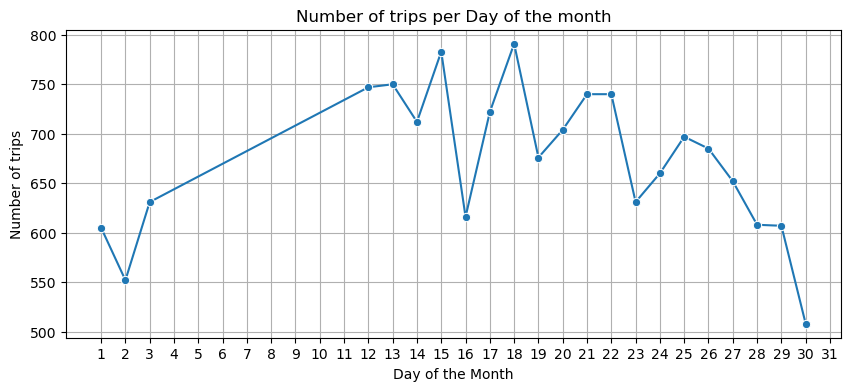

In [1113]:
# Count number of trip per day
df_day = df2.groupby(by = 'trip_creation_day')['trip_uuid'].count().reset_index()

# Rename the trip_uuid to trip_count
df_day.rename(columns = {'trip_uuid' : 'trip_count'}, inplace = True)

plt.figure(figsize = (10,4))
sns.lineplot(data = df_day, x = 'trip_creation_day', y = 'trip_count', marker = 'o')
plt.xticks(np.arange(1,32)) # 1-31 days
plt.grid('both')
plt.title("Number of trips per Day of the month")
plt.xlabel("Day of the Month")
plt.ylabel("Number of trips")
plt.show()

# Observation:
- The number of trips remains mostly between 600 and 750 throughout the month, with some ups and down
- The highest number of trips ocuured on day 18, with nearly 790 trips, There is also a notable spike on day 15
- The Lowest number of trips is observed on Day 30, with Just over 500 trips.
- Between day 12 and Day 18, there is clear increase in trips.

### **COUNT TRIPS BY WEEK**

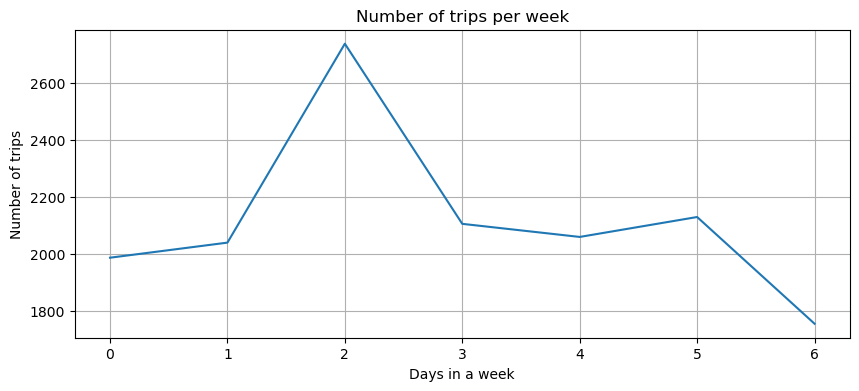

In [1116]:
# Count number of trip per day
df_week = df2.groupby(by = 'trip_weekday')['trip_uuid'].count().reset_index()

# Rename the trip_uuid to trip_count
df_week.rename(columns = {'trip_uuid' : 'trip_count'}, inplace = True)

plt.figure(figsize = (10,4))
sns.lineplot(data = df_week, x = 'trip_weekday', y = 'trip_count')
plt.grid('both')
plt.title("Number of trips per week")
plt.xlabel("Days in a week")
plt.ylabel("Number of trips")
plt.show()

# Observation:
- The highest number of trips occurs on Day2 means Tuesday
- Around 2700+ trips are made on this day.
- Day 6 means sunday has the lowest number of trips, around 1750 trips.
- From Monday(0) to Wednesday(2), there's a clear increase in trips, after that decline from wednesday onwards, slightly bunp on saturady(5)

### **COUNT TRIPS BY MONTH**

                     trip_uuid  Percentage
trip_creation_month                       
9                        13029       87.93
10                        1788       12.07


[]

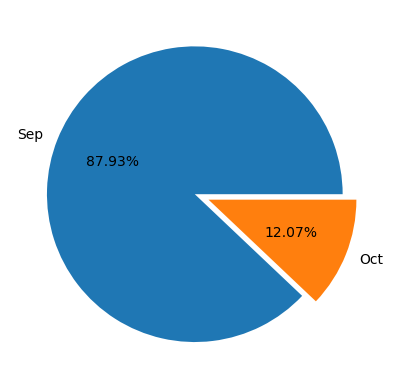

In [1119]:
df_month = df2.groupby(by = 'trip_creation_month')['trip_uuid'].count().to_frame()

# Calcualte Percentage share of trips per month
df_month['Percentage'] = np.round(df_month['trip_uuid'] * 100/ df_month['trip_uuid'].sum(),2)
print(df_month.head())
plt.pie(x = df_month['trip_uuid'], labels = ['Sep','Oct'], explode = [0,0.1], autopct = "%.2f%%")
plt.plot()

# Observation:
- 87.93% of all trips occured in september
- This means almost 9 out of every 10 trips happened in that month.
- October has much fewer trips
- only 12.07% of trips took place in october
- The october segment is also visually highlighted with an orange 'Explode Effect'.

### **COUNT TRIPS BY DATA**

          trip_uuid  Percentage
data                           
test           4163        28.1
training      10654        71.9


C:\Users\hp\AppData\Local\Temp\ipykernel_24020\3039679129.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_data = df2.groupby(by = 'data')['trip_uuid'].count().to_frame()


[]

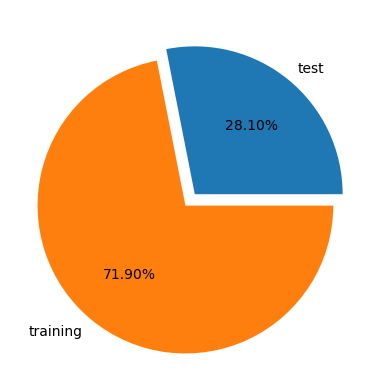

In [1122]:
df_data = df2.groupby(by = 'data')['trip_uuid'].count().to_frame()
df_data['Percentage'] = np.round(df_data['trip_uuid'] * 100/ df_data['trip_uuid'].sum(),2)
print(df_data.head())
plt.pie(x = df_data['trip_uuid'], labels = df_data.index, explode = [0,0.1], autopct = "%.2f%%")
plt.plot()

# Observation:
- Training data makes up the Majority
- 71.90% of the total data is used for training.
- Test data is smaller portion
- 28.10% is allocated for testing the model.

### **COUNT TRIPS BY ROUTE TYPE**

C:\Users\hp\AppData\Local\Temp\ipykernel_24020\1918470508.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_route = df2.groupby(by = 'route_type')['trip_uuid'].count().to_frame().reset_index()


  route_type  trip_uuid  Percentage
0    Carting       8908       60.12
1        FTL       5909       39.88


[]

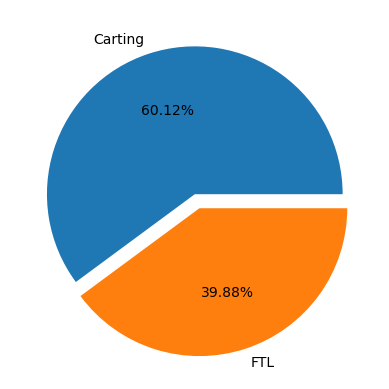

In [1125]:
df_route = df2.groupby(by = 'route_type')['trip_uuid'].count().to_frame().reset_index()
df_route['Percentage'] = np.round(df_route['trip_uuid'] * 100/ df_route['trip_uuid'].sum(),2)
print(df_route.head())
plt.pie(x = df_route['trip_uuid'], labels = ['Carting', 'FTL'], explode = [0,0.1], autopct = "%.2f%%")
plt.plot()

# Observation:
- Carting is more common, 60.2% of the trips are carting type, Indicates that the majority of logistics operations rely on shorter
- FTL(Full Truck Load) is less Frequent
- 39.88% of the trips are FTL
- These are likely longer distance or bulk delieveries.

### **DISTRIBUTION OF NUMBER OF TRIPS CREATED FROM DIFFERENT STATES**

     source_state  trip_uuid  Percentage
17    Maharashtra       2714       18.32
14      Karnataka       2143       14.46
10        Haryana       1838       12.40
24     Tamil Nadu       1039        7.01
25      Telangana        781        5.27
26  Uttar Pradesh        762        5.14
9         Gujarat        750        5.06
7           Delhi        728        4.91
28    West Bengal        665        4.49
22         Punjab        536        3.62


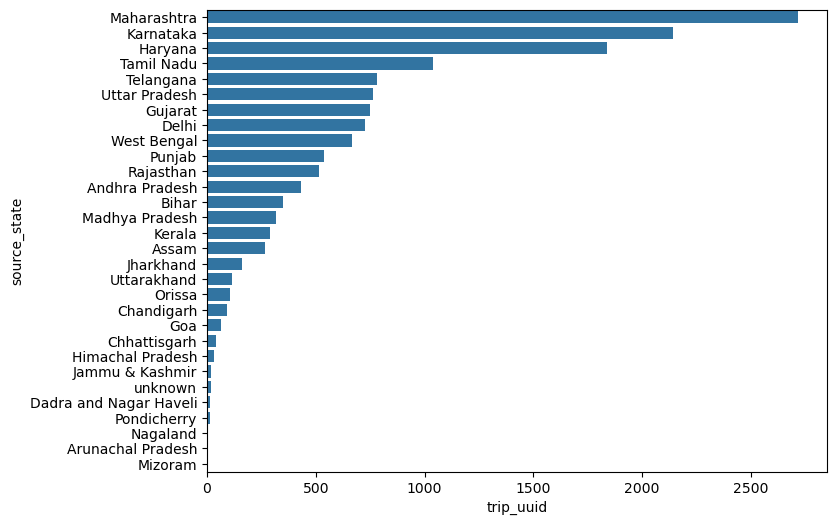

In [1128]:
# Grouping the dataset by 'source_state' and counting the number of trips from each state
df_source_state = df2.groupby(by = 'source_state')['trip_uuid'].count().to_frame().reset_index()

# Calculating the percentage share of each state in the total number of trips
df_source_state['Percentage'] =  np.round(df_source_state['trip_uuid'] * 100/ df_source_state['trip_uuid'].sum(),2)
df_source_state = df_source_state.sort_values(by = 'trip_uuid', ascending = False)
print(df_source_state.head(10))

plt.figure(figsize = (8,6))
sns.barplot(data = df_source_state, x = 'trip_uuid', y = 'source_state')
plt.show()

# Observation:
- Maharashtra has the highest number of trips, 2,714 trips, which accounts for 18.32% of all trips.
- It is the top-performing source state in terms of trip volume
- Karnataka: 2143 trips
- Haryana : 1838 trips
- Other states with moderate contributions:
  - Tamilnadu
  - Telangana
  - Uttar Pradesh, Gujart, and Delhi all contribute around 5% Each
- States Like west Bengal and Punjab have relatively Lower shares.
  - Below 5% Indicating fewer trips originate from these regions.

### **Source City - Wise Trip Distribution**

    source_city  trip_uuid  Percentage
439      Mumbai       1442        9.73
237     Gurgaon       1165        7.86
169       Delhi        883        5.96
79    Bengaluru        726        4.90
100    Bhiwandi        697        4.70
58    Bangalore        648        4.37
136     Chennai        568        3.83
264   Hyderabad        524        3.54
516        Pune        480        3.24
357     Kolkata        356        2.40


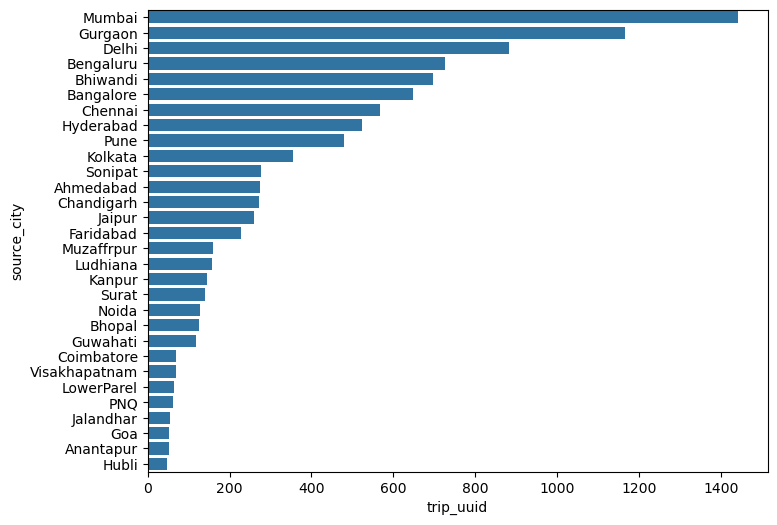

In [1131]:
# Grouping the dataset by 'source_city' and counting the number of trips from each state
df_source_city = df2.groupby(by = 'source_city')['trip_uuid'].count().to_frame().reset_index()

# Calculating the percentage share of each state in the total number of trips
df_source_city['Percentage'] =  np.round(df_source_city['trip_uuid'] * 100/ df_source_city['trip_uuid'].sum(),2)
df_source_city = df_source_city.sort_values(by = 'trip_uuid', ascending = False)
print(df_source_city.head(10))

plt.figure(figsize = (8,6))
x = df_source_city['trip_uuid'].head(30)
y = df_source_city['source_city'].head(30)
sns.barplot(x = x, y = y)
plt.show()

# Observation:
- Mumbai leads with the highest number of trips:
  - 1,442, Contributing 9.73% of the total.
  - Indicates it is major logistics or operational hub
- Gurgoan and delhi follow next:
  - Gurgoan : 1,165 trips
  - Delhi : 883 trips
- Mid--range Contributing cities include:
  - Bengaluru, Bhiwandi, & Bnaglore
  - These are also important cities in terms of network coverage and trip volumes
- Lower - Contribution cities:
  - Pune, Kolkata have smaller shares
  - May indicate limited operations or lower demand.

### **Destination State-Wise Trip Distribution**

   destination_state  trip_uuid  Percentage
18       Maharashtra       2561       17.28
15         Karnataka       2294       15.48
11           Haryana       1643       11.09
25        Tamil Nadu       1084        7.32
28     Uttar Pradesh        811        5.47
26         Telangana        784        5.29
10           Gujarat        734        4.95
30       West Bengal        697        4.70
8              Delhi        652        4.40
23            Punjab        617        4.16


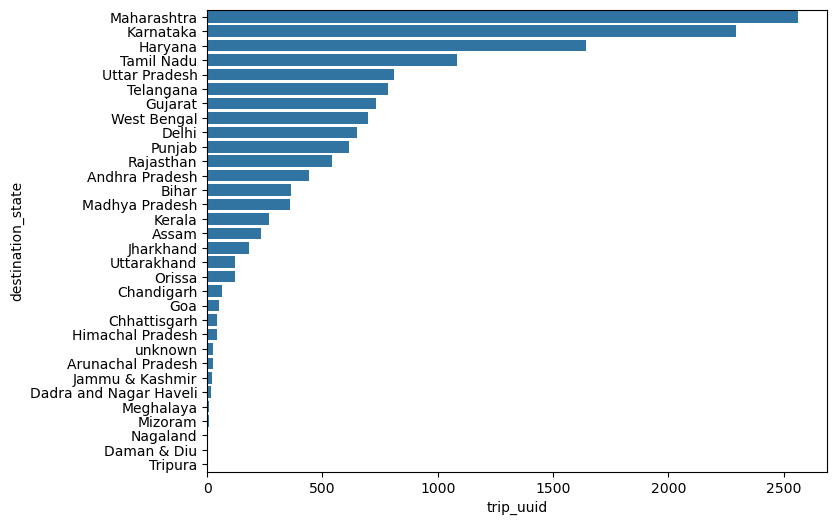

In [1134]:
# Grouping the dataset by 'source_state' and counting the number of trips from each state
df_destination_state = df2.groupby(by = 'destination_state')['trip_uuid'].count().to_frame().reset_index()

# Calculating the percentage share of each state in the total number of trips
df_destination_state['Percentage'] =  np.round(df_destination_state['trip_uuid'] * 100/ df_destination_state['trip_uuid'].sum(),2)
df_destination_state = df_destination_state.sort_values(by = 'trip_uuid', ascending = False)
print(df_destination_state.head(10))

plt.figure(figsize = (8,6))
sns.barplot(data = df_destination_state, x = 'trip_uuid', y = 'destination_state')
plt.show()

# Observation:
- **Top 3 Destination States:**
  - Maharashtra tops the list with 2,561 trips, contributing 17.28%
  - Karnataka follows with 15.48%
  - Haryana is next at 11.09%
  - Together, these three states account for 44% of all trips, Indicatig High delivery demand or hub presence
- **Mid-Tier Destination States:**
  - Tamilnadu, uttar pradesh, and Telangana show a moderate number of trips.
  - These are likely regional Distribution Zones
- **Lower Contribution States:**
  - Gujarat, west Bengal, Delhi, and Punjab have relatively fewer Deliveries


### **Destination City-Wise Trip Distribution**

    destination_city  trip_uuid  Percentage
515           Mumbai       1548       10.45
96         Bengaluru        975        6.58
282          Gurgaon        936        6.32
200            Delhi        778        5.25
163          Chennai        595        4.02
72         Bangalore        551        3.72
308        Hyderabad        503        3.39
115         Bhiwandi        434        2.93
418          Kolkata        384        2.59
158       Chandigarh        339        2.29


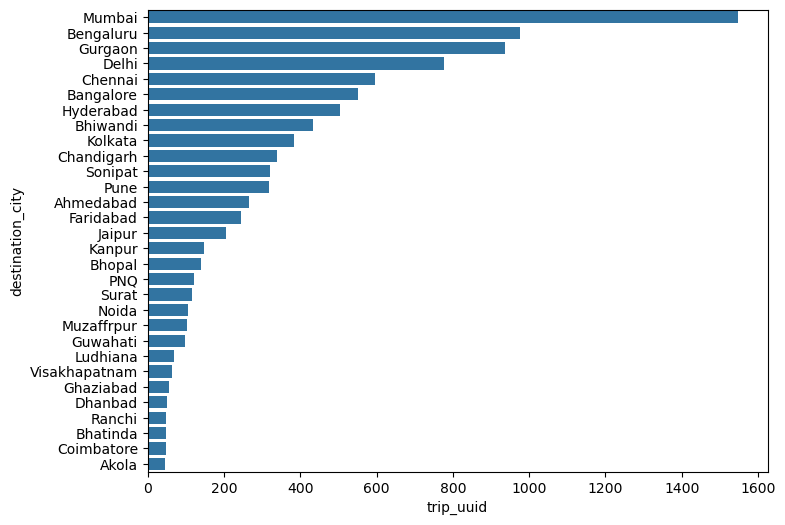

In [1137]:
# Grouping the dataset by 'source_city' and counting the number of trips from each state
df_destination_city = df2.groupby(by = 'destination_city')['trip_uuid'].count().to_frame().reset_index()

# Calculating the percentage share of each state in the total number of trips
df_destination_city['Percentage'] =  np.round(df_destination_city['trip_uuid'] * 100/ df_destination_city['trip_uuid'].sum(),2)
df_destination_city = df_destination_city.sort_values(by = 'trip_uuid', ascending = False)
print(df_destination_city.head(10))

plt.figure(figsize = (8,6))
x = df_destination_city['trip_uuid'].head(30)
y = df_destination_city['destination_city'].head(30)
sns.barplot(x = x, y = y)
plt.show()

# Observation:
- **Top Destination Cities:**
  - Mumbai is the clear leader with the highest number of trips(around 1550+ trips). indicating its role as a major logistic hub.
  - Bengaluru, Gurgoan, and Delhi also have a significant number of deliveries (Between 900-1000 trips each), Reflecting strong demand in metro cities.
- **Mid-Tier Cities:**
  - Cities Like Chennai, Hyderabad, Banglore, and Bhiwandi have moderate Delivery volumes (500-700) Trips, likely regional hubs or warehousing locations.
  - These cities represent a well-distribution delivery network across different zones


In [1139]:
df2

,trip_uuid,source_center,destination_center,data,route_type,trip_creation_time,source_name,destination_name,od_total_time,start_scan_to_end_scan,...,destination_city,source_place,destination_place,trip_creation_date,trip_creation_day,trip_creation_month,trip_creation_year,trip_creation_hour,trip_weekday,trip_weekofyear
0,trip-153671041653548748,IND209304AAA,IND209304AAA,training,FTL,2018-09-12 00:00:16.535741,Kanpur_Central_H_6 (Uttar Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),2260.11,2259.0,...,Kanpur,Central_H_6,Central_H_6,2018-09-12,12,9,2018,0,2,37
1,trip-153671042288605164,IND561203AAB,IND561203AAB,training,Carting,2018-09-12 00:00:22.886430,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),181.61,180.0,...,Doddablpur,ChikaDPP_D,ChikaDPP_D,2018-09-12,12,9,2018,0,2,37
2,trip-153671043369099517,IND000000ACB,IND000000ACB,training,FTL,2018-09-12 00:00:33.691250,Gurgaon_Bilaspur_HB (Haryana),Gurgaon_Bilaspur_HB (Haryana),3934.36,3933.0,...,Gurgaon,Bilaspur_HB,Bilaspur_HB,2018-09-12,12,9,2018,0,2,37
3,trip-153671046011330457,IND400072AAB,IND401104AAA,training,Carting,2018-09-12 00:01:00.113710,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra),100.49,100.0,...,Mumbai,unknown_place,MiraRd_IP,2018-09-12,12,9,2018,0,2,37
4,trip-153671052974046625,IND583101AAA,IND583119AAA,training,FTL,2018-09-12 00:02:09.740725,Bellary_Dc (Karnataka),Sandur_WrdN1DPP_D (Karnataka),718.34,717.0,...,Sandur,Dc,WrdN1DPP_D,2018-09-12,12,9,2018,0,2,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153861095625827784,IND160002AAC,IND160002AAC,test,Carting,2018-10-03 23:55:56.258533,Chandigarh_Mehmdpur_H (Punjab),Chandigarh_Mehmdpur_H (Punjab),258.03,257.0,...,Chandigarh,Mehmdpur_H,Mehmdpur_H,2018-10-03,3,10,2018,23,2,40
14813,trip-153861104386292051,IND121004AAB,IND121004AAA,test,Carting,2018-10-03 23:57:23.863155,FBD_Balabhgarh_DPC (Haryana),Faridabad_Blbgarh_DC (Haryana),60.59,60.0,...,Faridabad,Balabhgarh_DPC,Blbgarh_DC,2018-10-03,3,10,2018,23,2,40
14814,trip-153861106442901555,IND208006AAA,IND208006AAA,test,Carting,2018-10-03 23:57:44.429324,Kanpur_GovndNgr_DC (Uttar Pradesh),Kanpur_GovndNgr_DC (Uttar Pradesh),422.12,421.0,...,Kanpur,GovndNgr_DC,GovndNgr_DC,2018-10-03,3,10,2018,23,2,40
14815,trip-153861115439069069,IND627005AAA,IND628204AAA,test,Carting,2018-10-03 23:59:14.390954,Tirunelveli_VdkkuSrt_I (Tamil Nadu),Tirchchndr_Shnmgprm_D (Tamil Nadu),348.52,347.0,...,Tirchchndr,VdkkuSrt_I,Shnmgprm_D,2018-10-03,3,10,2018,23,2,40


### **PAIRS PLOTS**

[]

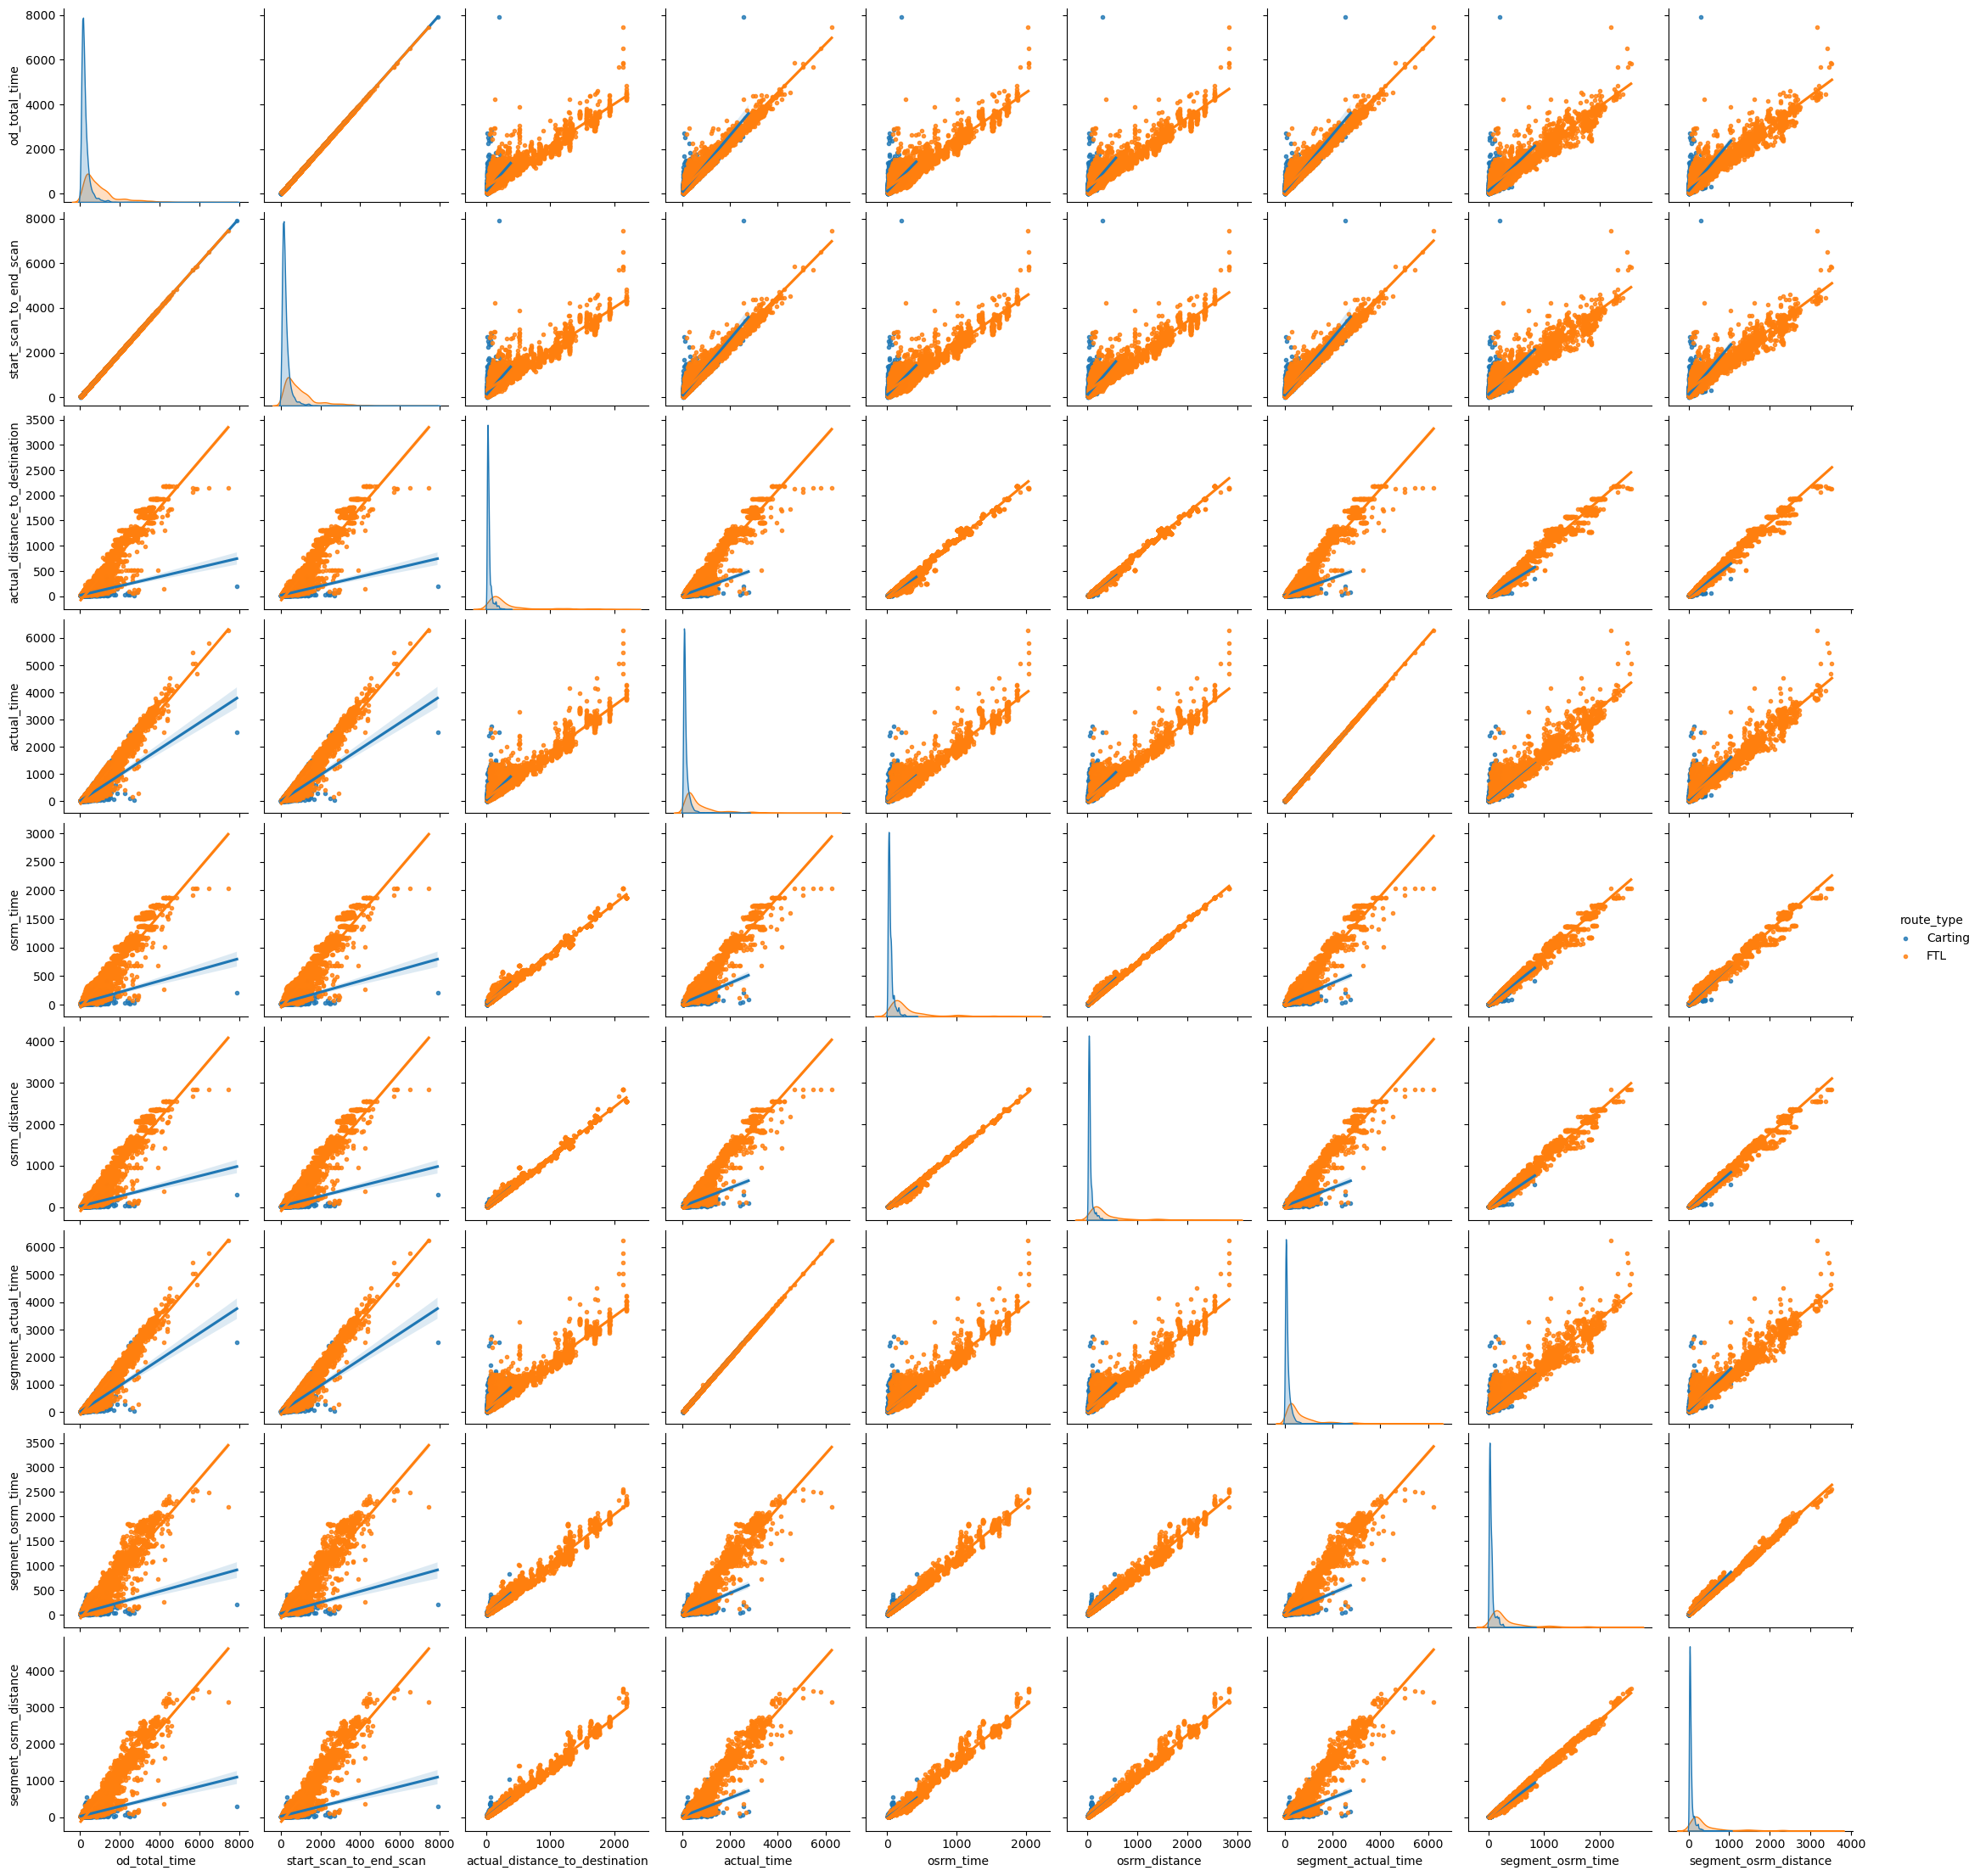

In [1141]:
# Select key numerical columns like related to time & Distance
numerical_columns = ['od_total_time',
                     'start_scan_to_end_scan',
                     'actual_distance_to_destination',
                     'actual_time',
                     'osrm_time',
                     'osrm_distance',
                     'segment_actual_time',
                     'segment_osrm_time','segment_osrm_distance']

# Create a pairplot with regression line
sns.pairplot(data = df2, vars = numerical_columns, kind ='reg', hue = 'route_type', markers = '.' )
plt.plot()

### **CORRELATION**

In [1143]:
df_corr = df2[numerical_columns].corr()
df_corr.T

,od_total_time,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
od_total_time,1.000000,0.999999,0.918222,0.961094,0.926516,0.924219,0.961119,0.918490,0.919199
start_scan_to_end_scan,0.999999,1.000000,0.918308,0.961147,0.926571,0.924299,0.961171,0.918561,0.919291
actual_distance_to_destination,0.918222,0.918308,1.000000,0.953757,0.993561,0.997264,0.952821,0.987538,0.993061
actual_time,0.961094,0.961147,0.953757,1.000000,0.958593,0.959214,0.999989,0.953872,0.956967
osrm_time,0.926516,0.926571,0.993561,0.958593,1.000000,0.997580,0.957765,0.993259,0.991608
osrm_distance,0.924219,0.924299,0.997264,0.959214,0.997580,1.000000,0.958353,0.991798,0.994710
segment_actual_time,0.961119,0.961171,0.952821,0.999989,0.957765,0.958353,1.000000,0.953039,0.956106
segment_osrm_time,0.918490,0.918561,0.987538,0.953872,0.993259,0.991798,0.953039,1.000000,0.996092
segment_osrm_distance,0.919199,0.919291,0.993061,0.956967,0.991608,0.994710,0.956106,0.996092,1.000000


### **HEATMAP**

[]

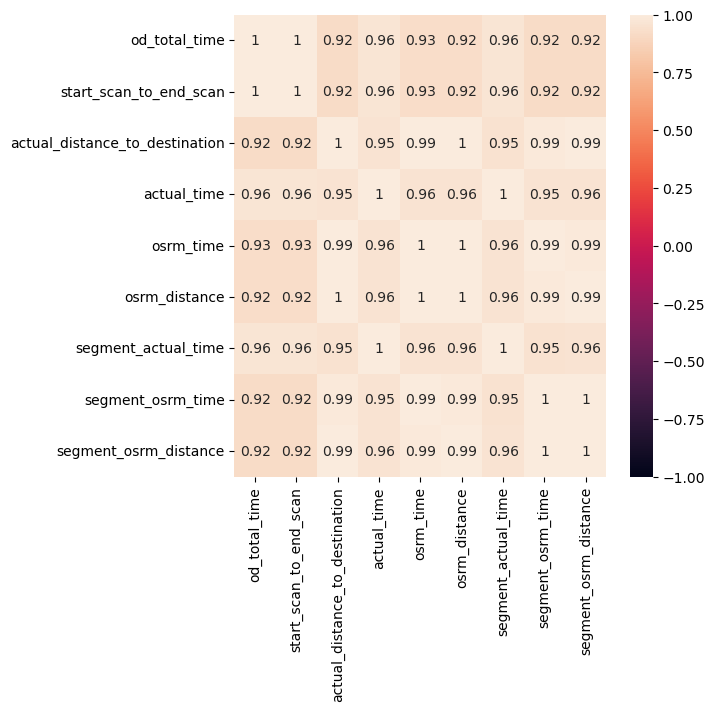

In [1145]:
plt.figure(figsize = (6,6))
sns.heatmap(data = df_corr, vmin = -1, vmax = 1, annot = True)
plt.plot()

# Observations:
- **Many columns are very similar**
  - For example: od_total_time, actual_time, and start_scan_to_end_scan give almost the same information.
  - Same with distance columns like actual_distance_to_destination, osrm_distance, and segment_osrm_distance.
- **Very high numbers (close to 1) mean strong connection**
  - If two values are close to 1.00, it means they change together (they are strongly related).

### **IN-DEPTH ANALYSIS AND FEATURE ENGINEERING**
- Compare the difference between actual total trip time and expected trip time (od_total_time & start_scan_to_end_scan)
- Perform hypothesis testing and visual analysis to check if they differ significantly.
- **DEFINE HYPOTHESES**
  - **NULL HYPOTHESIS(H0):**
    - There is no significant difference between od_start_time & start_scan_to_end_scan
      - H0: Mean = Mean
  - **ALTERNATE HYPOTHESIS(H1):**
    - There is a significant difference between od_total_time and start_scan_to_end_scan
      - H1: Mean != Mean
- **CHECK ASSUMPTIONS FOR HYPOTHESIS TESTING**
  - Before chossing the right test, we must verify these assumptions:
    - **Normality Check:**
      - Use QQ plot or shapiro-wilk test to check if both variables are normally distributed.
    - **Homogeneity of variance**
      - Use levene's test to check if the variances of both groups are equal
- **CHOOSE THE RIGHT STATISTICAL TEST:**
  - If both assumptions hold true:
    - Use Independent sample t-test (if samples are independent)
    - Use Paired t-test (if comparing same trip observations)
  - If Assumptions Fail:
    - Use a Non-Parametric alternative, Like Mann-Whitney U test
- **SET THE SIGNIFICANCE LEVEL**
  - alpha = 0.05
- **MAKE A DECISION USING P-VALUE:**
  - Comapre p-value to alpha
  - if p_value > alpha: Failed to reject H0 : There's no siginificant difference
  - if p_value < alpha: Failed to reject H0 : There's siginificant difference


## **TOTAL TRIP TIME VS. EXPECTED SCAN TIME**
- Comparing two numerical features od_start_time and start_scan_to_end_scan for same trip
- Using the visual checks, Normality test, and appropriate hypothesis tests
  - Paired t-test or Mann-Whitney U test, depending on distribution.

In [1149]:
df2[['od_total_time', 'start_scan_to_end_scan']].describe()

,od_total_time,start_scan_to_end_scan
count,14817.000000,14817.000000
mean,531.697630,530.810016
std,658.868223,658.705957
min,23.460000,23.000000
25%,149.930000,149.000000
50%,280.770000,280.000000
75%,638.200000,637.000000
max,7898.550000,7898.000000


**DISTRIBUTION OF BOTH VARIABLES**

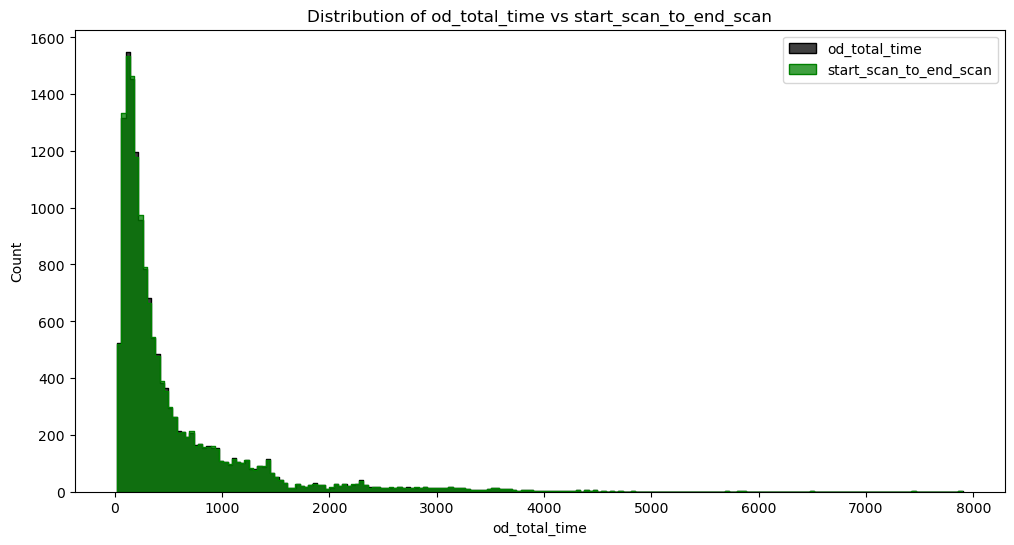

In [1151]:
plt.figure(figsize = (12,6))
sns.histplot(df2['od_total_time'], color = 'black', element = 'step', label = 'od_total_time')
sns.histplot(df2['start_scan_to_end_scan'], color='green', element='step', label='start_scan_to_end_scan')
plt.legend()
plt.title("Distribution of od_total_time vs start_scan_to_end_scan")
plt.show()

### **Shapiro-Wilk Normality Test**

In [1153]:
from scipy import stats as spy

# Step 1: Apply Shapiro-Wilk test on a sample (e.g., 5000 records)
test_stat, p_value = spy.shapiro(df2['od_total_time'].sample(5000, random_state=42))
print("Shapiro-Wilk test p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("The sample does NOT follow a normal distribution (Reject H₀)")
else:
    print("The sample follows a normal distribution (Fail to reject H₀)")

Shapiro-Wilk test p-value: 0.0
The sample does NOT follow a normal distribution (Reject H₀)


In [1154]:
# Step 1: Apply Shapiro-Wilk test on a sample (e.g., 5000 records)
test_stat, p_value = spy.shapiro(df2['start_scan_to_end_scan'].sample(5000, random_state=42))
print("Shapiro-Wilk test p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("The sample does NOT follow a normal distribution (Reject H₀)")
else:
    print("The sample follows a normal distribution (Fail to reject H₀)")

Shapiro-Wilk test p-value: 0.0
The sample does NOT follow a normal distribution (Reject H₀)


### **Mann–Whitney U Test**

In [1156]:
from scipy.stats import mannwhitneyu

stat, p_val = mannwhitneyu(df2['od_total_time'], df2['start_scan_to_end_scan'])
print(f"Mann-Whitney U Test p-value: {p_val}")

alpha = 0.05
if p_val < alpha:
    print("Reject H0 — Significant difference exists.")
else:
    print("Fail to reject H0 — No significant difference.")

Mann-Whitney U Test p-value: 0.7815123224221716
Fail to reject H0 — No significant difference.


# Final Observation:
- The Analysis Indicates that there is no statistically significant difference between the Total trip time and expected scan time.

### **HYPOTHESIS TESTING: COMAPRING ACTUAL TRIP TIME VS. PREDICTED OSRM TRIP TIME**
- To determine whether the actual trip time (actual_time) significantly differs from the predicted OSRM trip time (osrm_time)

In [1159]:
# Descriptive statistics
df2[['actual_time', 'osrm_time']].describe()

,actual_time,osrm_time
count,14817.000000,14817.000000
mean,357.143754,161.384018
std,561.396157,271.360995
min,9.000000,6.000000
25%,67.000000,29.000000
50%,149.000000,60.000000
75%,370.000000,168.000000
max,6265.000000,2032.000000


### **DISTRIBUTION**

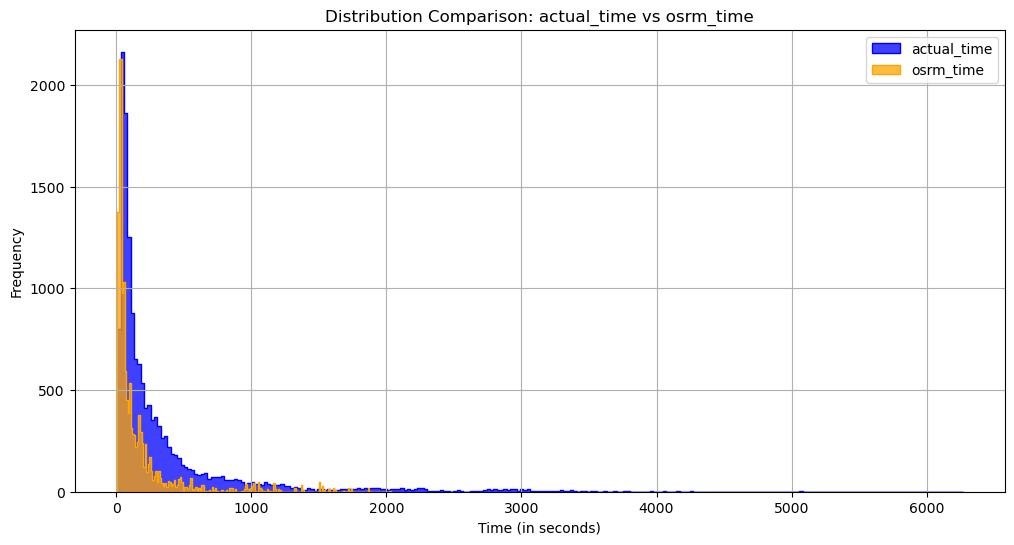

In [1161]:
# Plot histograms to compare distributions
plt.figure(figsize=(12, 6))
sns.histplot(df2['actual_time'], color='blue', label='actual_time', element='step')
sns.histplot(df2['osrm_time'], color='orange', label='osrm_time', element='step')
plt.legend()
plt.title('Distribution Comparison: actual_time vs osrm_time')
plt.xlabel('Time (in seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### **Test for Normality (Shapiro-Wilk Test)**

In [1163]:
from scipy import stats

# Shapiro-Wilk test for normality (on a sample due to large data)
shapiro_actual = stats.shapiro(df2['actual_time'].sample(5000))
shapiro_osrm = stats.shapiro(df2['osrm_time'].sample(5000))

print("p-value (actual_time):", shapiro_actual.pvalue)
print("p-value (osrm_time):", shapiro_osrm.pvalue)

# Interpretation
if shapiro_actual.pvalue < 0.05:
    print("actual_time does NOT follow normal distribution")
else:
    print("actual_time follows normal distribution")

if shapiro_osrm.pvalue < 0.05:
    print("osrm_time does NOT follow normal distribution")
else:
    print("osrm_time follows normal distribution")

p-value (actual_time): 0.0
p-value (osrm_time): 0.0
actual_time does NOT follow normal distribution
osrm_time does NOT follow normal distribution


### **Mann-Whitney U Test (Non-Parametric Test)**

In [1165]:
# Since data is not normal, use Mann-Whitney U Test
u_stat, p_val = stats.mannwhitneyu(df2['actual_time'], df2['osrm_time'])

print("Mann-Whitney U test p-value:", p_val)

if p_val < 0.05:
    print("Reject H₀: actual_time and osrm_time are significantly different")
else:
    print("Fail to Reject H₀: No significant difference")

Mann-Whitney U test p-value: 0.0
Reject H₀: actual_time and osrm_time are significantly different


# Observation:
- Indicating a statistically significant difference between the actual trip time and the predicted OSRM trip time.

### **HYPOTHESIS TESTING: ACTUAL DELIVERY TIME VS. SEGEMENT-LEVEL ACTUAL TIMES**
- To check if there is a statistically significant difference between the actual delivery time (actual_time) and the sum of segment-level actual times (segment_actual_time) after aggregation by trip_uuid.

### **Descriptive Statistics**

In [1169]:
# Descriptive summary of the two time features
df2[['actual_time', 'segment_actual_time']].describe()

,actual_time,segment_actual_time
count,14817.000000,14817.000000
mean,357.143754,353.892286
std,561.396157,556.247965
min,9.000000,9.000000
25%,67.000000,66.000000
50%,149.000000,147.000000
75%,370.000000,367.000000
max,6265.000000,6230.000000


### **Visual Distribution Check**

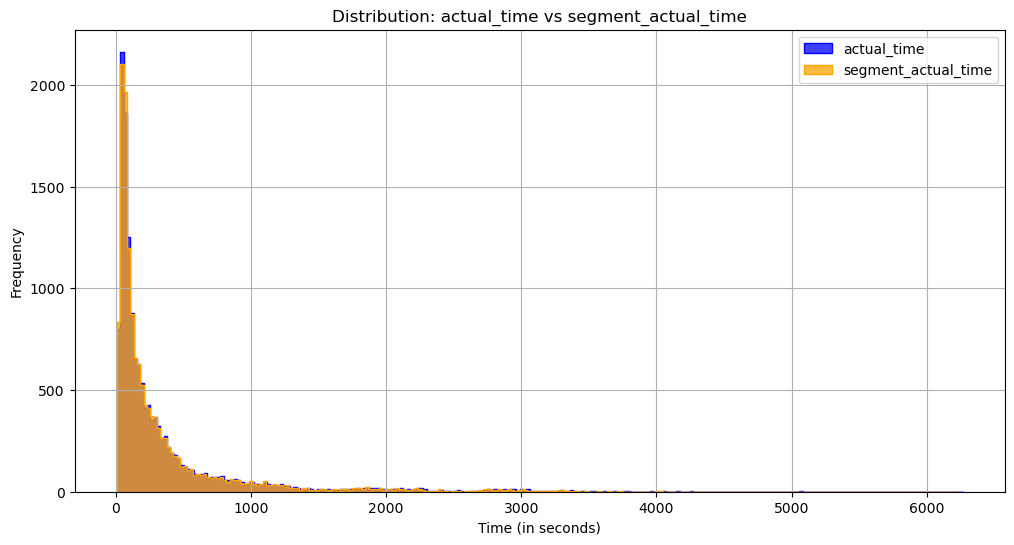

In [1171]:
plt.figure(figsize=(12, 6))
sns.histplot(df2['actual_time'], color='blue', element='step', label='actual_time')
sns.histplot(df2['segment_actual_time'], color='orange', element='step', label='segment_actual_time')
plt.legend()
plt.title('Distribution: actual_time vs segment_actual_time')
plt.xlabel('Time (in seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### **Test for Normality (Shapiro-Wilk Test)**

In [1173]:
from scipy.stats import shapiro

# Sample (because Shapiro-Wilk is sensitive to large data)
stat1, p1 = shapiro(df2['actual_time'].sample(5000))
stat2, p2 = shapiro(df2['segment_actual_time'].sample(5000))

print("Shapiro p-value (actual_time):", p1)
print("Shapiro p-value (segment_actual_time):", p2)

if p1 < 0.05:
    print("actual_time is NOT normally distributed")
else:
    print("actual_time is normally distributed")

if p2 < 0.05:
    print("segment_actual_time is NOT normally distributed")
else:
    print("segment_actual_time is normally distributed")

Shapiro p-value (actual_time): 0.0
Shapiro p-value (segment_actual_time): 0.0
actual_time is NOT normally distributed
segment_actual_time is NOT normally distributed


### **Mann–Whitney U Test (Non-parametric Test)**

In [1175]:
from scipy.stats import mannwhitneyu

u_stat, p_mwu = mannwhitneyu(df2['actual_time'], df2['segment_actual_time'])
print("Mann–Whitney U Test p-value:", p_mwu)

if p_mwu < 0.05:
    print("Reject H₀: actual_time and segment_actual_time are significantly different")
else:
    print("Fail to Reject H₀: No significant difference")

Mann–Whitney U Test p-value: 0.4164235159622476
Fail to Reject H₀: No significant difference


#Observation:
- Concluding that there is no statistically significant difference between the actual delivery time and the sum of segment-level actual times.

### **OSRM DISTANCE VS. SEGMENT OSRM DISTANCE**
- To determine whether the OSRM route distance and the sum of segment-level OSRM distances are statistically different.

### **Descriptive Statistics**

In [1179]:
# View descriptive statistics
df2[['osrm_distance', 'segment_osrm_distance']].describe()

,osrm_distance,segment_osrm_distance
count,14817.000000,14817.000000
mean,204.344689,223.201161
std,370.395573,416.628374
min,9.072900,9.072900
25%,30.819200,32.654500
50%,65.618800,70.154400
75%,208.475000,218.802400
max,2840.081000,3523.632400


### **Visual Analysis - Distribution Check**

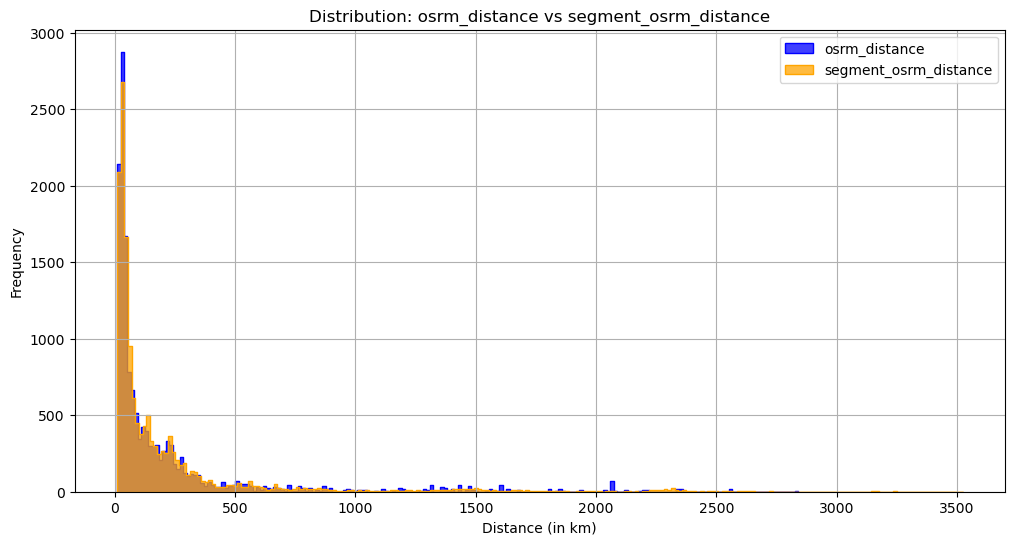

In [1181]:
plt.figure(figsize=(12, 6))
sns.histplot(df2['osrm_distance'], color='blue', element='step', label='osrm_distance')
sns.histplot(df2['segment_osrm_distance'], color='orange', element='step', label='segment_osrm_distance')
plt.legend()
plt.title('Distribution: osrm_distance vs segment_osrm_distance')
plt.xlabel('Distance (in km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### **Normality Check — Shapiro-Wilk Test**

In [1183]:
from scipy.stats import shapiro

# Sampling because Shapiro is sensitive to large datasets
stat1, p1 = shapiro(df2['osrm_distance'].sample(5000))
stat2, p2 = shapiro(df2['segment_osrm_distance'].sample(5000))

print("Shapiro p-value (osrm_distance):", p1)
print("Shapiro p-value (segment_osrm_distance):", p2)

if p1 < 0.05:
    print("osrm_distance is NOT normally distributed")
else:
    print("osrm_distance is normally distributed")

if p2 < 0.05:
    print("segment_osrm_distance is NOT normally distributed")
else:
    print("segment_osrm_distance is normally distributed")

Shapiro p-value (osrm_distance): 0.0
Shapiro p-value (segment_osrm_distance): 0.0
osrm_distance is NOT normally distributed
segment_osrm_distance is NOT normally distributed


### **Mann–Whitney U Test (non-parametric)**

In [1185]:
from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(df2['osrm_distance'], df2['segment_osrm_distance'])
print("Mann–Whitney U Test p-value:", p_val)

if p_val < 0.05:
    print("Reject H₀: osrm_distance and segment_osrm_distance are significantly different")
else:
    print("Fail to Reject H₀: No significant difference between the two")

Mann–Whitney U Test p-value: 9.511383588276373e-07
Reject H₀: osrm_distance and segment_osrm_distance are significantly different


# Observation:
- Therefore, there is a statistically significant difference between the OSRM route distance and the sum of segment-level OSRM distances.

### **OSRM TIME VS. SEGMENT OSRM TIME**
- To determine whether there's a statistically significant difference between osrm_time (OSRM-predicted total time) and segment_osrm_time (sum of segment-level OSRM times).

### **Descriptive Statistics**

In [1189]:
# Summary statistics
df2[['osrm_time', 'segment_osrm_time']].describe().T

,count,mean,std,min,25%,50%,75%,max
osrm_time,14817.0,161.384018,271.360995,6.0,29.0,60.0,168.0,2032.0
segment_osrm_time,14817.0,180.949787,314.542047,6.0,31.0,65.0,185.0,2564.0


### **Visual Distribution Check**

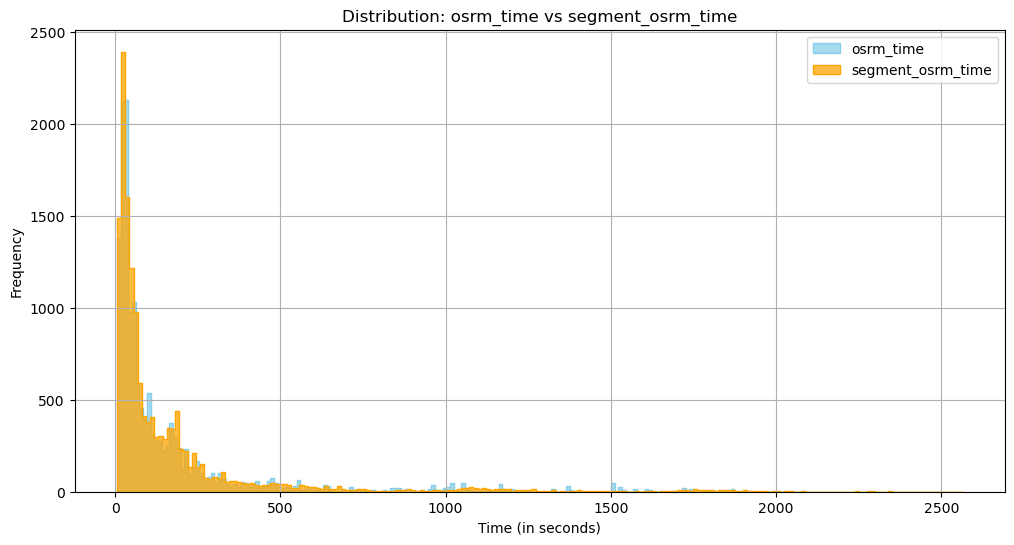

In [1191]:
plt.figure(figsize=(12, 6))
sns.histplot(df2['osrm_time'], label='osrm_time', element='step', color='skyblue')
sns.histplot(df2['segment_osrm_time'], label='segment_osrm_time', element='step', color='orange')
plt.title('Distribution: osrm_time vs segment_osrm_time')
plt.xlabel('Time (in seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

### **Normality Test — Shapiro-Wilk**

In [1193]:
from scipy.stats import shapiro

# Run test on a sample of 5000 due to large size
stat1, p1 = shapiro(df2['osrm_time'].sample(5000))
stat2, p2 = shapiro(df2['segment_osrm_time'].sample(5000))

print("Shapiro p-value (osrm_time):", p1)
print("Shapiro p-value (segment_osrm_time):", p2)

if p1 < 0.05:
    print("osrm_time is NOT normally distributed")
else:
    print("osrm_time is normally distributed")

if p2 < 0.05:
    print("segment_osrm_time is NOT normally distributed")
else:
    print("segment_osrm_time is normally distributed")

Shapiro p-value (osrm_time): 0.0
Shapiro p-value (segment_osrm_time): 0.0
osrm_time is NOT normally distributed
segment_osrm_time is NOT normally distributed


### **Mann–Whitney U Test (Non-parametric)**

In [1195]:
from scipy.stats import mannwhitneyu

u_stat, p_val = mannwhitneyu(df2['osrm_time'], df2['segment_osrm_time'])
print("Mann–Whitney U Test p-value:", p_val)

if p_val < 0.05:
    print("Reject H₀ → There is a significant difference between osrm_time and segment_osrm_time")
else:
    print("Fail to Reject H₀ → No significant difference between osrm_time and segment_osrm_time")

Mann–Whitney U Test p-value: 2.2995370859748865e-08
Reject H₀ → There is a significant difference between osrm_time and segment_osrm_time


# Observation:
- Therefore, there is a statistically significant difference between the OSRM-predicted total time and the sum of its segment-level OSRM times.

## **DETECTING OUTLIERS IN NUMERICAL VARIABLES**
- To Identify outliers in the numerical variables using boxplots and statistical summaries.
- The selected columns are all continuous numerical features that represent various time and distance measurements.

In [1198]:
numerical_columns = ['od_total_time','start_scan_to_end_scan','actual_distance_to_destination',
                     'actual_time', 'osrm_time', 'osrm_distance',
                     'segment_actual_time','segment_osrm_time','segment_osrm_distance']

# Statistical summary for all selected numerical features
df2[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
od_total_time,14817.0,531.697630,658.868223,23.460000,149.930000,280.770000,638.200000,7898.550000
start_scan_to_end_scan,14817.0,530.810016,658.705957,23.000000,149.000000,280.000000,637.000000,7898.000000
actual_distance_to_destination,14817.0,164.477838,305.388147,9.002461,22.837239,48.474072,164.583208,2186.531787
actual_time,14817.0,357.143754,561.396157,9.000000,67.000000,149.000000,370.000000,6265.000000
osrm_time,14817.0,161.384018,271.360995,6.000000,29.000000,60.000000,168.000000,2032.000000
osrm_distance,14817.0,204.344689,370.395573,9.072900,30.819200,65.618800,208.475000,2840.081000
segment_actual_time,14817.0,353.892286,556.247965,9.000000,66.000000,147.000000,367.000000,6230.000000
segment_osrm_time,14817.0,180.949787,314.542047,6.000000,31.000000,65.000000,185.000000,2564.000000
segment_osrm_distance,14817.0,223.201161,416.628374,9.072900,32.654500,70.154400,218.802400,3523.632400


### **DISTRIBUTION OF NUMERICAL COLUMNS**
- To visualize the distribution of each numerical column using histograms along with KDE Curves to understand the shape, skewness, and spread of the data.

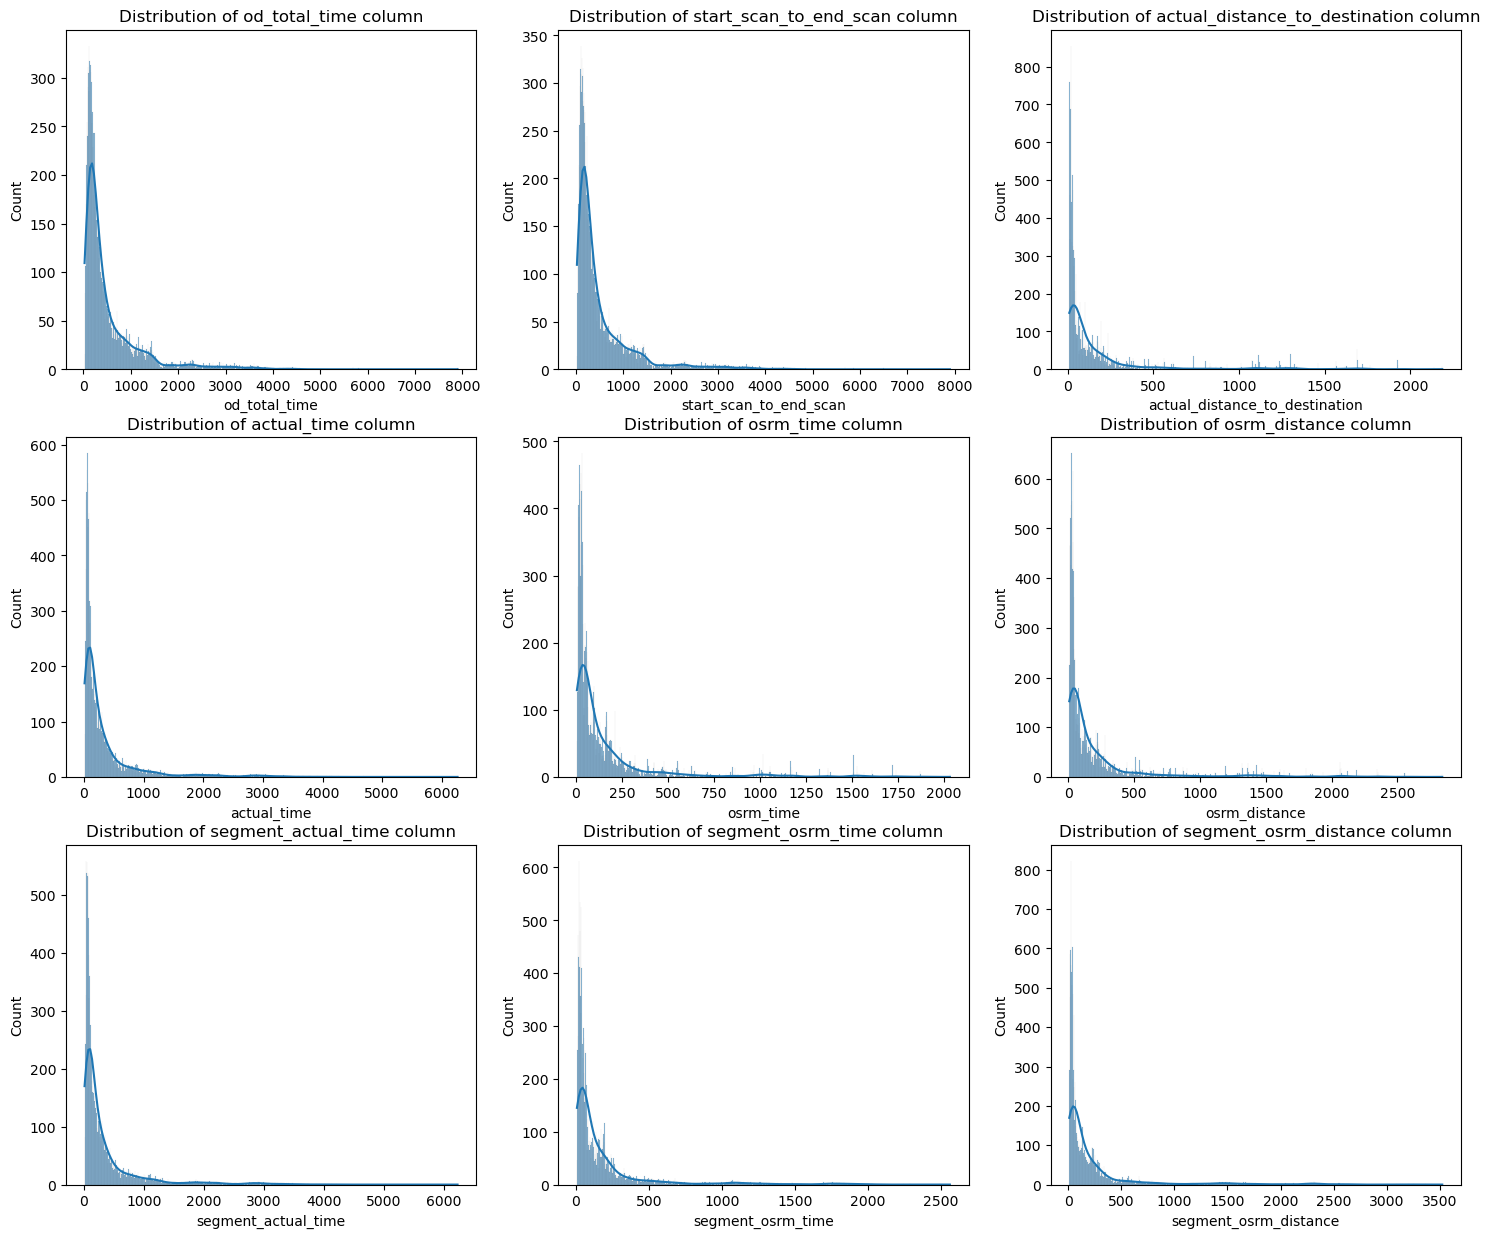

In [1200]:
plt.figure(figsize = (18,15))
for i in range(len(numerical_columns)):
  plt.subplot(3,3, i+1)
  sns.histplot(df2[numerical_columns[i]], bins=1000, kde=True)
  plt.title(f"Distribution of {numerical_columns[i]} column")
  plt.plot()

# Observation:
- **Skewed Distribution**
  - All columns are right-skewed (long tail to the right).
  - Most values are small (towards the left), and only a few are very large.
- **Majority of Trips Are Short**
  - Whether it’s time (like od_total_time, osrm_time, actual_time) or distance (like actual_distance_to_destination, osrm_distance), most trips are quick or short.
- **Some Outliers**
  - There are a few trips with very high values (visible as long tails), which could be outliers or special cases.
- **Similar Patterns Across Columns**
  - All columns follow a similar shape, showing that trip duration and distance values are consistent in pattern across various calculated metrics.

### **VISUAL OUTLIER DETECTION USING BOXPLOTS**

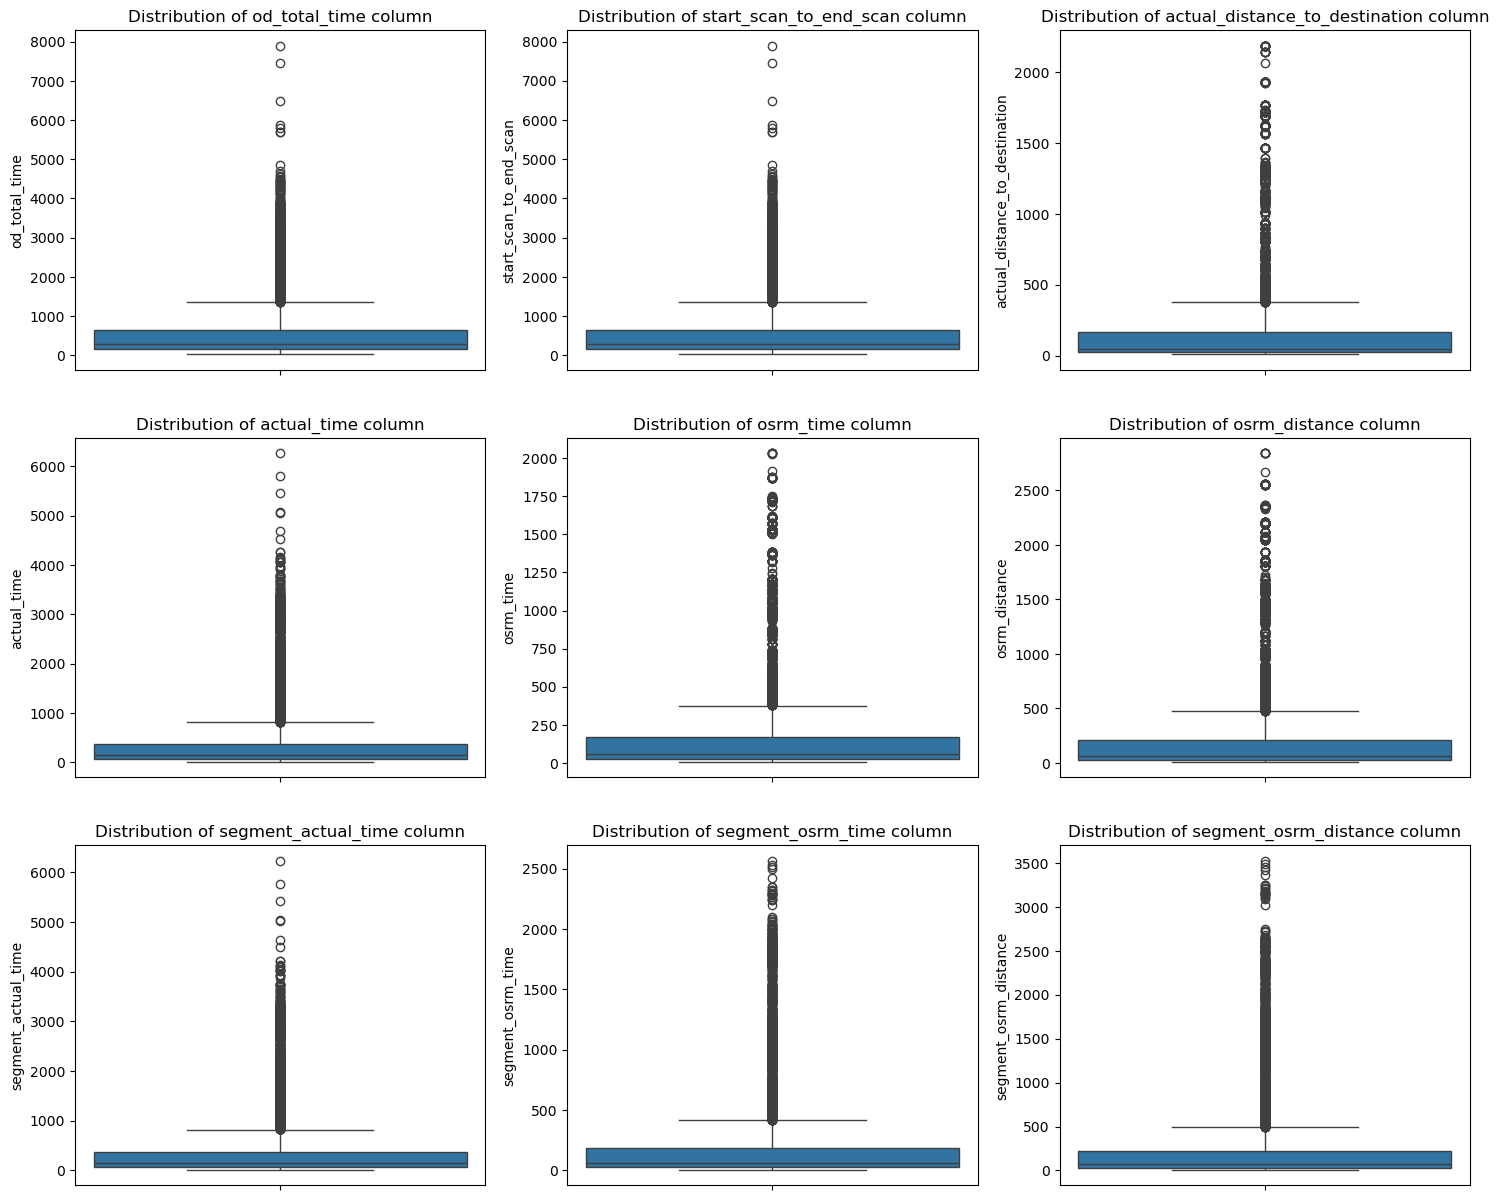

In [1203]:
plt.figure(figsize = (18,15))
for i in range(len(numerical_columns)):
  plt.subplot(3,3, i+1)
  sns.boxplot(df2[numerical_columns[i]])
  plt.title(f"Distribution of {numerical_columns[i]} column")
  plt.plot()

## Observation:
- For almost all the measurements most of the trips were very short.
- All plots contains Outliers.
- Indicating a wide range in the maximum values for distance and time.

- **Detecting Outliers using IQR method**

In [1206]:
# Detecting outliers using IQR Method
for i in numerical_columns:
  Q1 = np.quantile(df2[i], 0.25)
  Q3 = np.quantile(df2[i], 0.75)
  IQR = Q3-Q1
  LB = Q1-1.5*IQR
  UB = Q3+1.5*IQR
  outliers = df2.loc[(df2[i]<LB) | (df2[i]>UB)]
  print('Column :', i)
  print(f'Q1 : {Q1}')
  print(f'Q3 : {Q3}')
  print(f'IQR : {IQR}')
  print(f'LB : {LB}')
  print(f'UB : {UB}')
  print(f'Number of outliers : {outliers.shape[0]}')
  print('---------------------------')

Column : od_total_time
Q1 : 149.93
Q3 : 638.2
IQR : 488.27000000000004
LB : -582.4750000000001
UB : 1370.605
Number of outliers : 1266
---------------------------
Column : start_scan_to_end_scan
Q1 : 149.0
Q3 : 637.0
IQR : 488.0
LB : -583.0
UB : 1369.0
Number of outliers : 1267
---------------------------
Column : actual_distance_to_destination
Q1 : 22.83723905859321
Q3 : 164.58320763841138
IQR : 141.74596857981817
LB : -189.78171381113404
UB : 377.2021605081386
Number of outliers : 1449
---------------------------
Column : actual_time
Q1 : 67.0
Q3 : 370.0
IQR : 303.0
LB : -387.5
UB : 824.5
Number of outliers : 1643
---------------------------
Column : osrm_time
Q1 : 29.0
Q3 : 168.0
IQR : 139.0
LB : -179.5
UB : 376.5
Number of outliers : 1517
---------------------------
Column : osrm_distance
Q1 : 30.8192
Q3 : 208.475
IQR : 177.6558
LB : -235.6645
UB : 474.9587
Number of outliers : 1524
---------------------------
Column : segment_actual_time
Q1 : 66.0
Q3 : 367.0
IQR : 301.0
LB : -385.

# Explaination:
- Q1 & Q3 represent the first and third quartiles
- These values are used to calculate the Interquartile range(IQR)
-IQR Measures the spread of the middle 50% of the data
- Data Points below LB or Above UB are considered  outliers
-  outliers = df2.loc[(df2[i] < LB) | (df2[i] > UB)]
- This line filters the DataFrame df2 to include only rows where values are less than LB or greater than UB.

### **Label Encoding of Categorical Variables**
- To convert the categorical variable into numerical format for machine Learning models, as most ML algorithms only work with numerical input.

In [1209]:
# Check value counts before Encoding
df2['route_type'].value_counts()

route_type
Carting    8908
FTL        5909
Name: count, dtype: int64

In [1210]:
# Encode the 'route_type' column using Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df2['route_type'] = label_encoder.fit_transform(df2['route_type'])

In [1211]:
df2['route_type'].value_counts()

route_type
0    8908
1    5909
Name: count, dtype: int64

### **Encoding Categorical Column 'data'**
- To convert the categorical column data, which contains the labels 'training' and 'testing'.

In [1213]:
# Value counts for 'data' column
df2['data'].value_counts()

data
training    10654
test         4163
Name: count, dtype: int64

In [1214]:
# Encode the data column using LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df2['data'] = label_encoder.fit_transform(df2['data'])

In [1215]:
df2['data'].value_counts()

data
1    10654
0     4163
Name: count, dtype: int64

### **FEATUTRE SCALING**

### **NORMALIZE THE NUMERICAL FEATURE**
- We Normalize Numerical Features to bring all values into a common scale, Which si especially important in many machine learning algorithms.
- Different units and Scales
  - Example: Age (0–100), Salary (10,000–1,00,000)
  - If not scaled, features with large values Dominate the model.
- Normalization helps models like gradient descent converge faster by keeping weights balanced.
- To rescale the Numerical columns to a range of [0,1], so that it contributes equally during modelling and does not dominate due to large magnitude.

[]

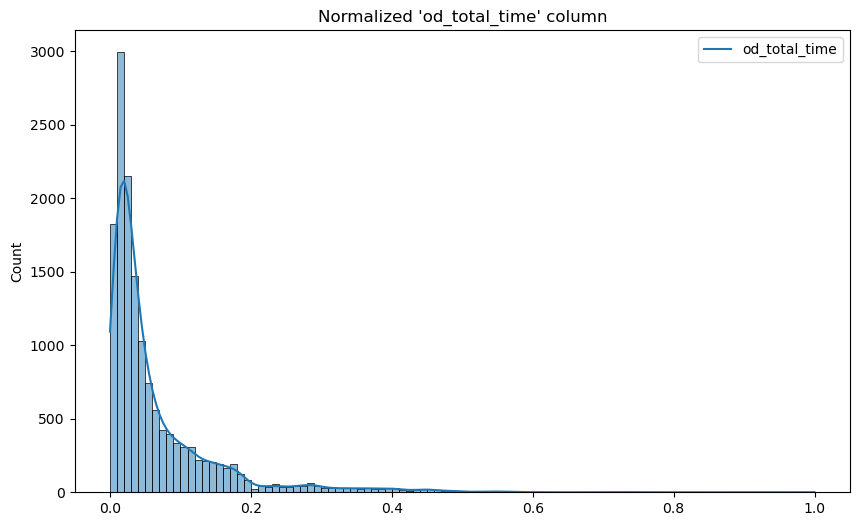

In [1218]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'od_total_time' column
scaled = scaler.fit_transform(df2['od_total_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'od_total_time' column")
plt.legend(['od_total_time'])
plt.plot()

## Observation:
- The od_total_time values are successfully scaled within the range of 0 and 1 as expected with MINMAXSCALER.
- Right-skewed Distribution, most values are concentrated near 0, with a long tail on the right
- A large number of trips scaled values below 0.1.
- A small number of trips have value above 0.3, presence of outliers.

[]

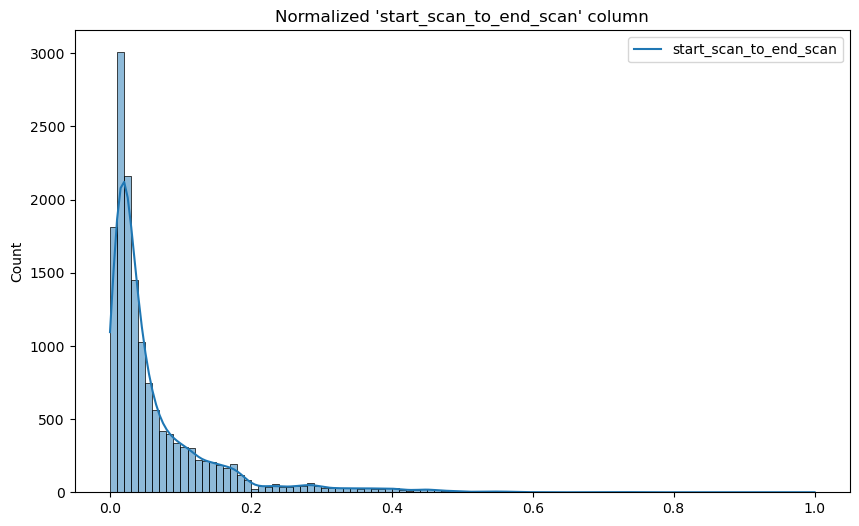

In [1220]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'start_scan_to_end_scan' column
scaled = scaler.fit_transform(df2['start_scan_to_end_scan'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'start_scan_to_end_scan' column")
plt.legend(['start_scan_to_end_scan'])
plt.plot()

[]

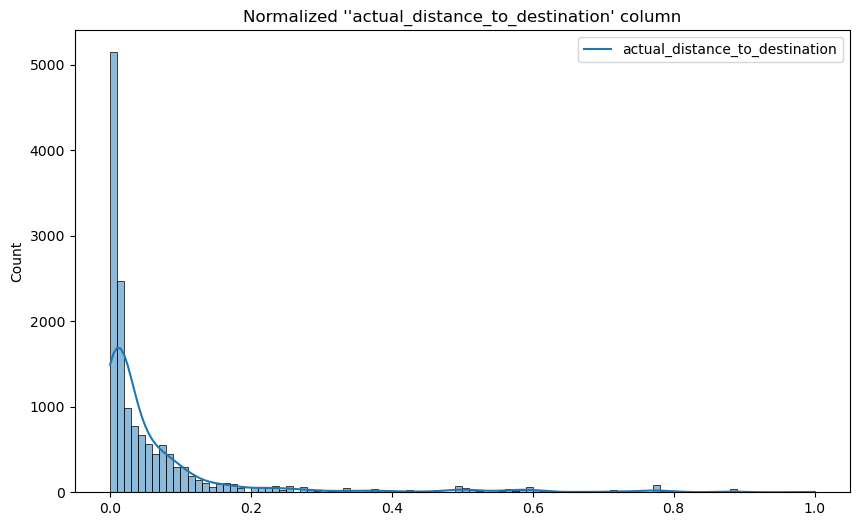

In [1221]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'actual_distance_to_destination' column
scaled = scaler.fit_transform(df2['actual_distance_to_destination'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized ''actual_distance_to_destination' column")
plt.legend(['actual_distance_to_destination'])
plt.plot()

[]

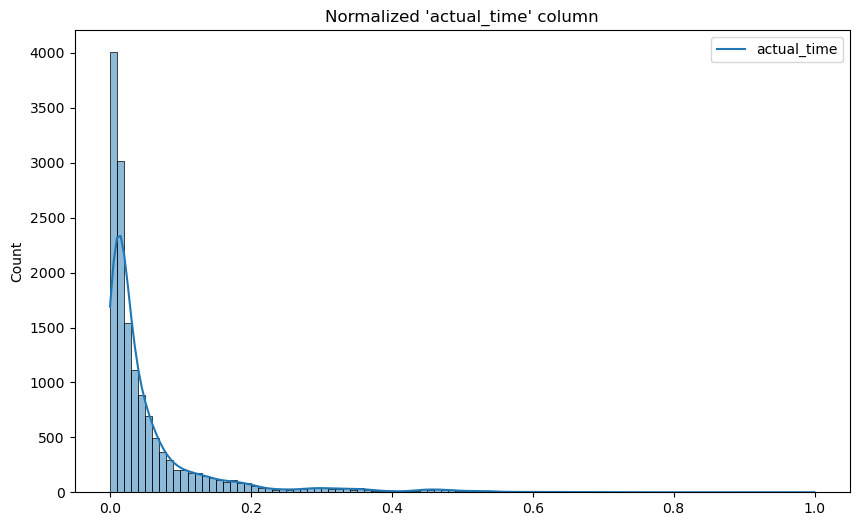

In [1222]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'actual_time' column
scaled = scaler.fit_transform(df2['actual_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'actual_time' column")
plt.legend(['actual_time'])
plt.plot()

[]

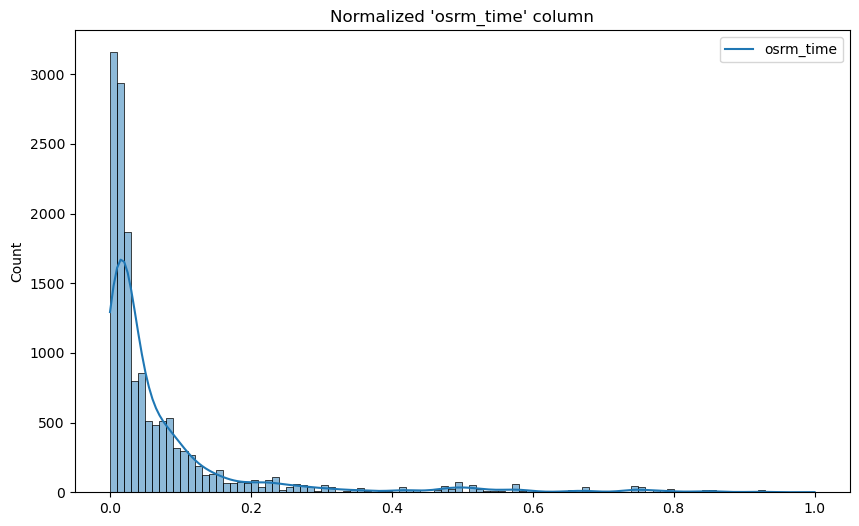

In [1223]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'osrm_time' column
scaled = scaler.fit_transform(df2['osrm_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'osrm_time' column")
plt.legend(['osrm_time'])
plt.plot()

[]

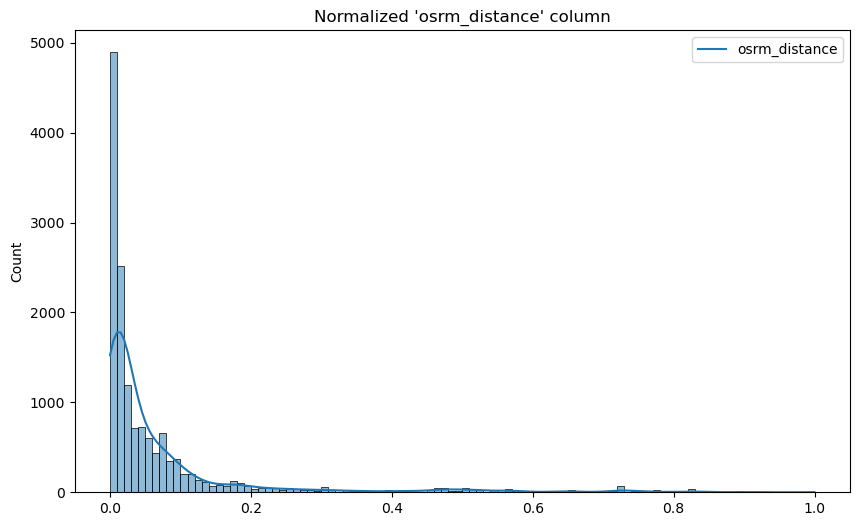

In [1224]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'osrm_distance' column
scaled = scaler.fit_transform(df2['osrm_distance'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'osrm_distance' column")
plt.legend(['osrm_distance'])
plt.plot()

[]

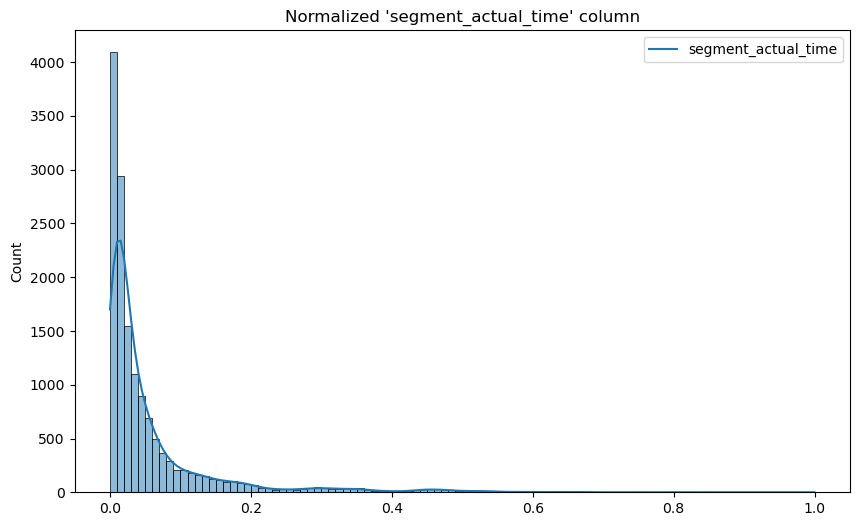

In [1225]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'segment_actual_time' column
scaled = scaler.fit_transform(df2['segment_actual_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'segment_actual_time' column")
plt.legend(['segment_actual_time'])
plt.plot()

[]

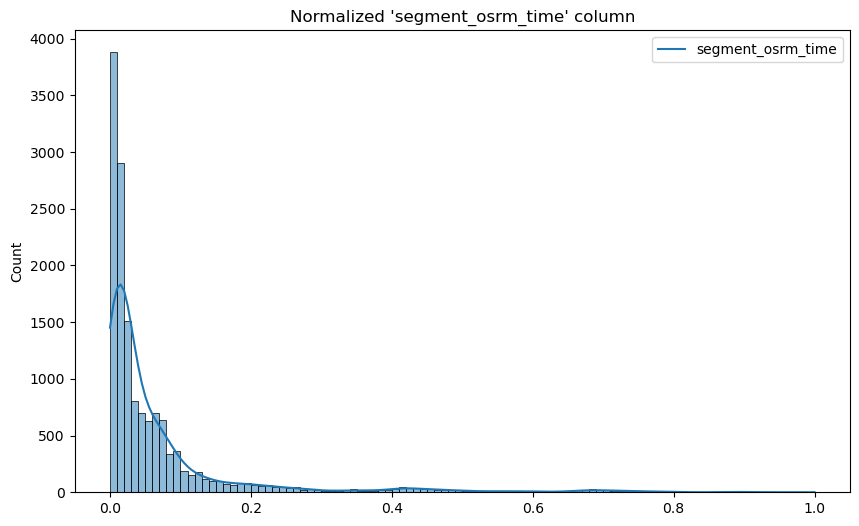

In [1226]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'segment_osrm_time' column
scaled = scaler.fit_transform(df2['segment_osrm_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'segment_osrm_time' column")
plt.legend(['segment_osrm_time'])
plt.plot()

[]

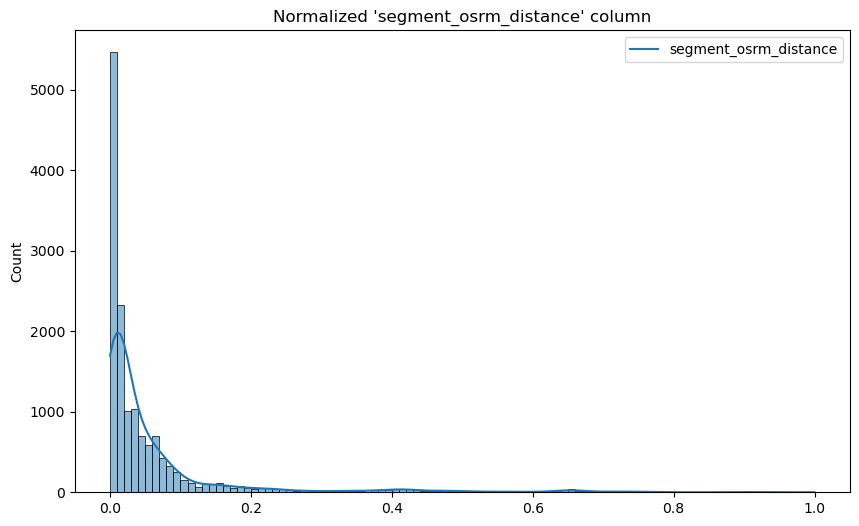

In [1227]:
# Create a MinMaxScaler Object
scaler = MinMaxScaler()

# Fit and transform the 'segment_osrm_distance' column
scaled = scaler.fit_transform(df2['segment_osrm_distance'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Normalized 'segment_osrm_distance' column")
plt.legend(['segment_osrm_distance'])
plt.plot()

### **STANDARDIZATION**
- We use standardization and standardscaler to transform numerical features so that they have mean of 0 a standard deviation of 1.
- This process is especially usefull when the data foloows a normal distribution OR When we want all features to be on standard scale.
- **WHY USE STANDARDIZATION**
  - **Centers the data:**
    - Makes the feature mean = 0, Which is helpfull for many algorithms that assume the data is centered.
    - Standardization is less sensitive to outliers beacause it does'nt compress the range to [0,1].

In [1229]:
from sklearn.preprocessing import StandardScaler

[]

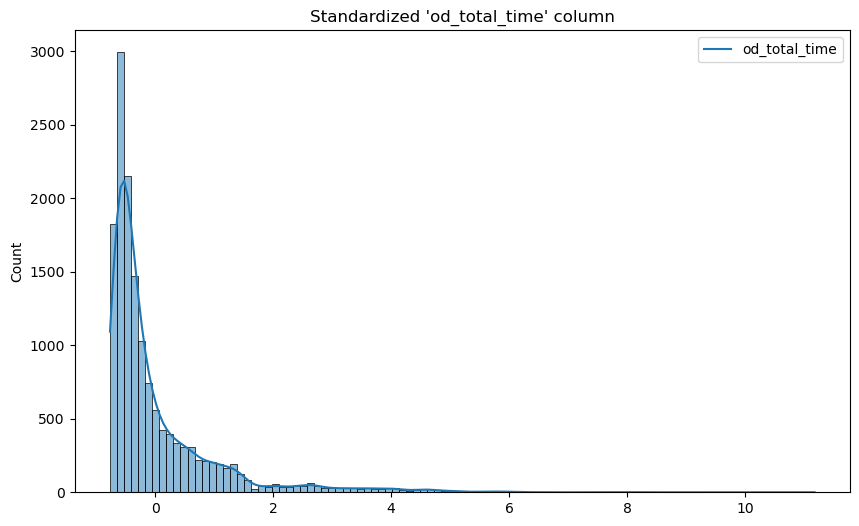

In [1230]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'od_total_time' column
scaled = scaler.fit_transform(df2['od_total_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'od_total_time' column")
plt.legend(['od_total_time'])
plt.plot()

[]

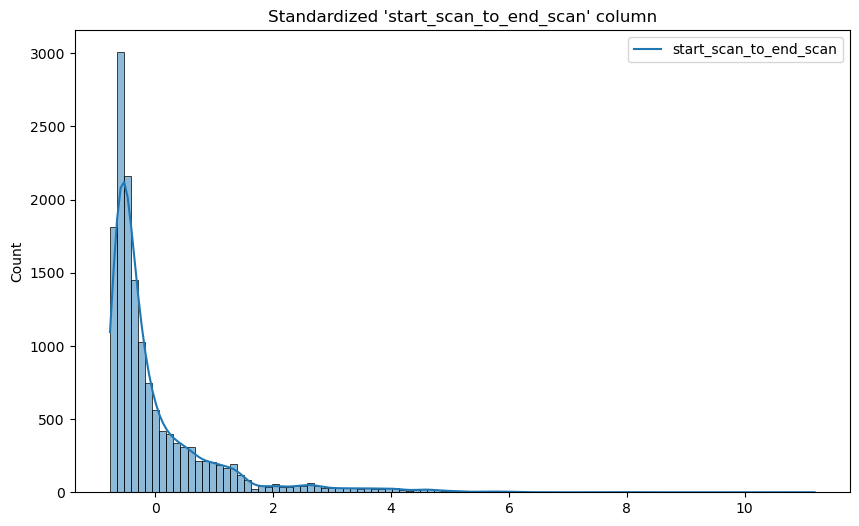

In [1231]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'start_scan_to_end_scan' column
scaled = scaler.fit_transform(df2['start_scan_to_end_scan'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'start_scan_to_end_scan' column")
plt.legend(['start_scan_to_end_scan'])
plt.plot()

[]

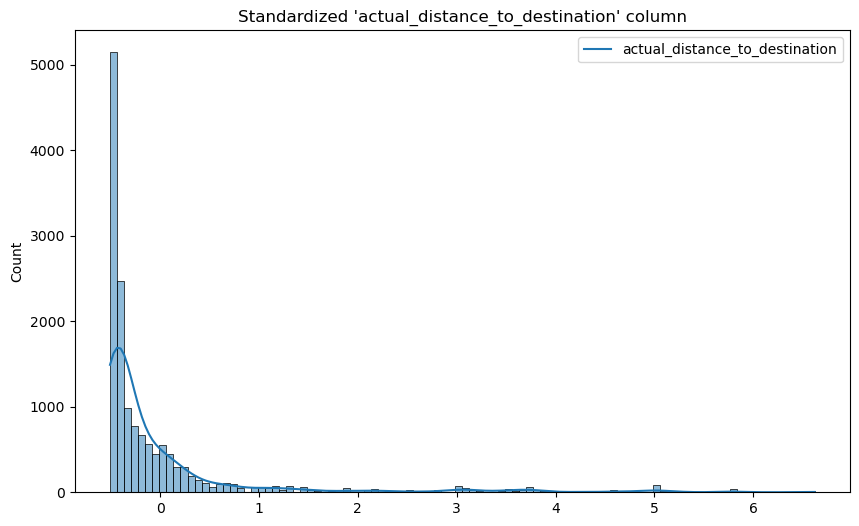

In [1232]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'actual_distance_to_destination' column
scaled = scaler.fit_transform(df2['actual_distance_to_destination'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'actual_distance_to_destination' column")
plt.legend(['actual_distance_to_destination'])
plt.plot()

[]

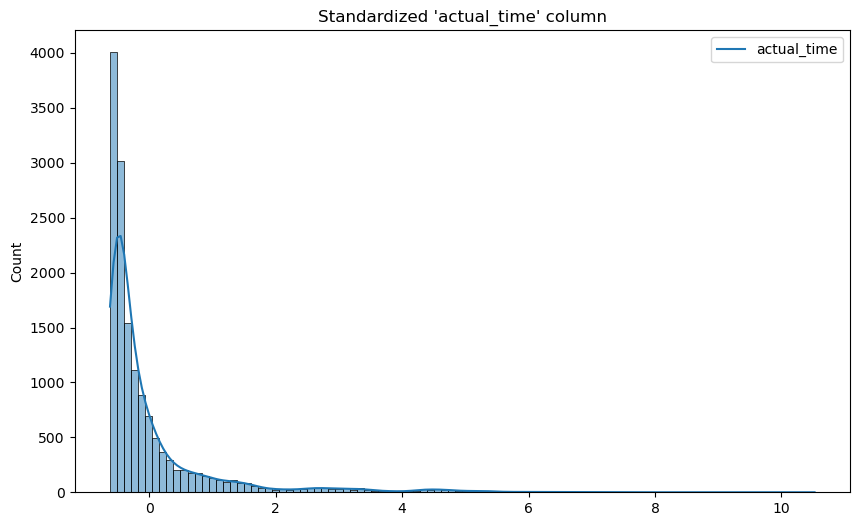

In [1233]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'actual_time' column
scaled = scaler.fit_transform(df2['actual_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'actual_time' column")
plt.legend(['actual_time'])
plt.plot()

[]

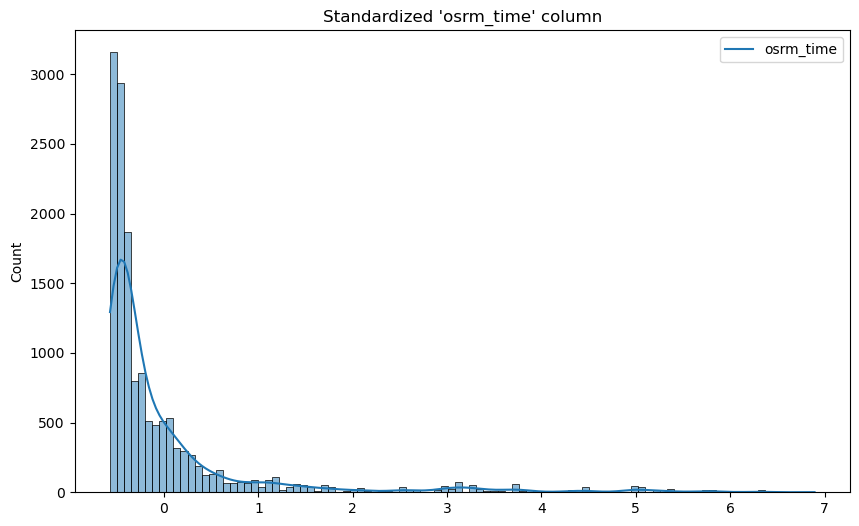

In [1234]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'osrm_time' column
scaled = scaler.fit_transform(df2['osrm_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'osrm_time' column")
plt.legend(['osrm_time'])
plt.plot()

[]

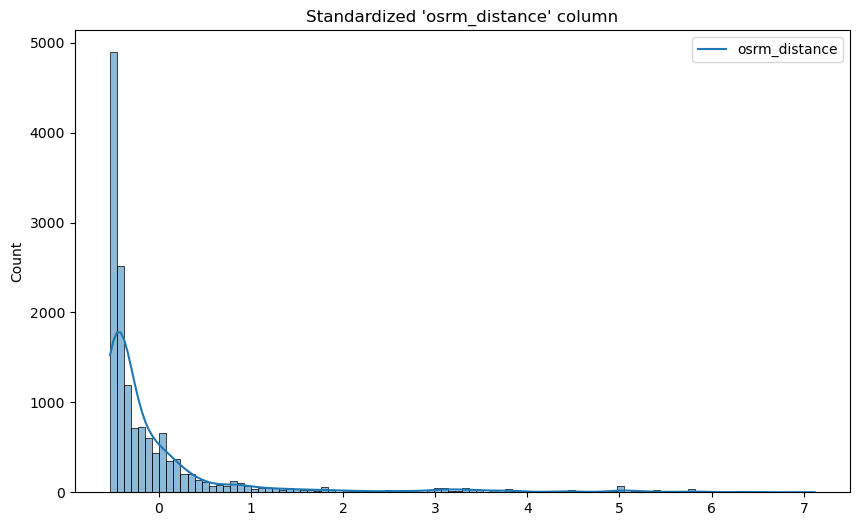

In [1235]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'osrm_distance' column
scaled = scaler.fit_transform(df2['osrm_distance'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'osrm_distance' column")
plt.legend(['osrm_distance'])
plt.plot()

[]

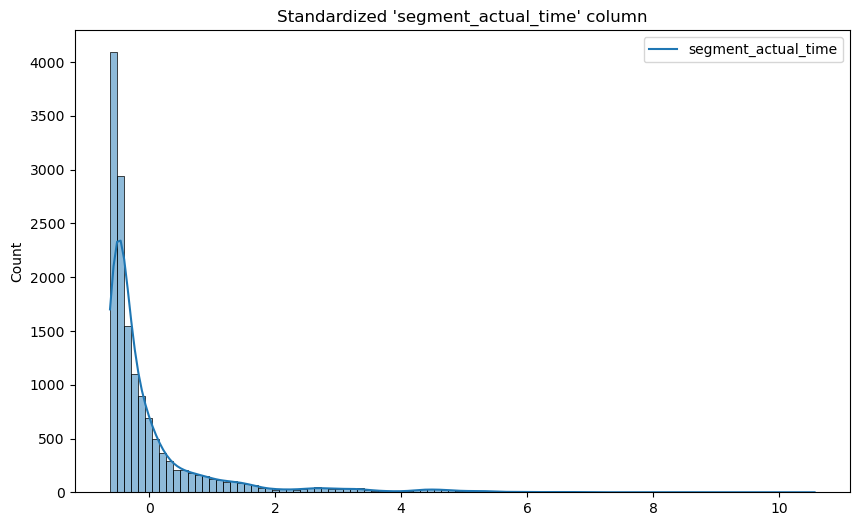

In [1236]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'segment_actual_time' column
scaled = scaler.fit_transform(df2['segment_actual_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'segment_actual_time' column")
plt.legend(['segment_actual_time'])
plt.plot()

[]

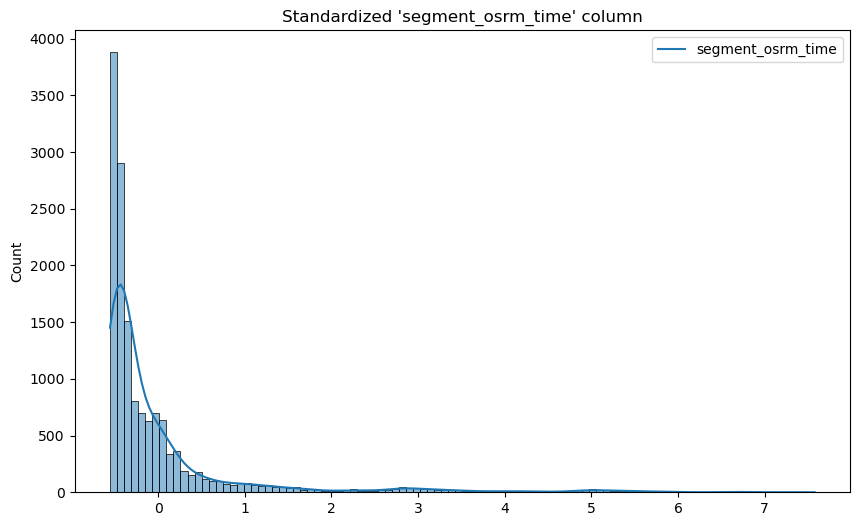

In [1237]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'segment_osrm_time'  column
scaled = scaler.fit_transform(df2['segment_osrm_time'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'segment_osrm_time' column")
plt.legend(['segment_osrm_time'])
plt.plot()

[]

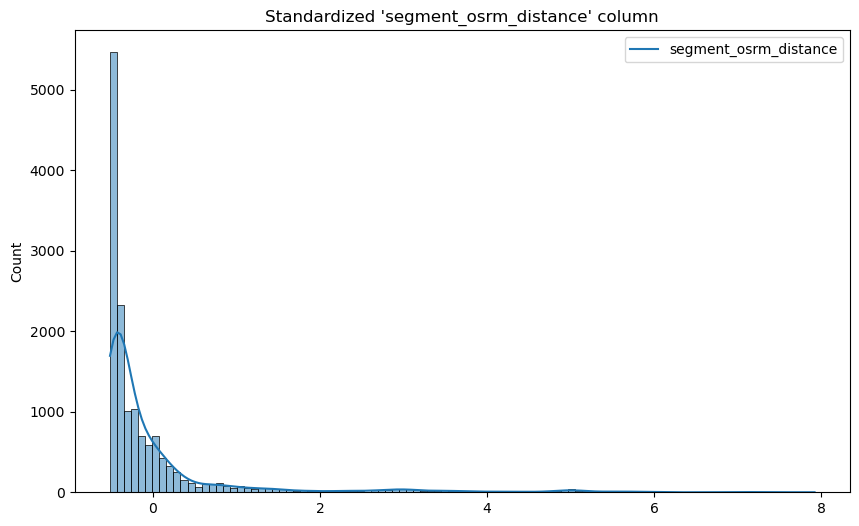

In [1238]:
# Create a Standard scaler Object
scaler = StandardScaler()

# Fit and transform the 'segment_osrm_distance' column
scaled = scaler.fit_transform(df2['segment_osrm_distance'].to_numpy().reshape(-1, 1))
plt.figure(figsize=(10, 6))
sns.histplot(scaled, bins=100, kde=True)
plt.title("Standardized 'segment_osrm_distance' column")
plt.legend(['segment_osrm_distance'])
plt.plot()

### **INSIGHTS**
- **Data Overview**
  - The dataset spans from 2018-09-12 to 2018-10-08, covering 14,817 unique trips, 1,508 source centers, and 1,481 destination centers.

- **Data Preprocessing**
  - About 293 source_name and 261 destination_name values were missing and filled with 'UNKNOWN'. All dates converted to datetime64.

- **Trip Aggregation**
  - Trips contain multiple segments. Aggregation by trip_uuid using first, last, and sum yielded a clean dataset of 14,817 rows (one per trip).

- **Temporal Patterns**
  - Trips peak at 10 PM. The busiest day of month is Day 18.

- **Weekly & Monthly Trends**
  - Tuesday (Day 2) sees the highest weekly trips. 87.93% of trips happened in September.

- **Geographic Demand – Source States**
  - Top 3 source states:
    - Maharashtra: 2,714 trips (18.32%)
    - Karnataka: 2,143 trips (14.47%)
    - Haryana: 1,838 trips (12.40%)

- **Geographic Demand – Destination Cities**
  - Top 5 cities for deliveries:
    - Mumbai: ~1,550 trips (10.46%)
    - Bengaluru: ~1,000+
    - Gurgaon: ~980+
    - Delhi: ~950+
    - Chennai: ~650+

- **Feature Correlation Insights**
  - od_total_time and start_scan_to_end_scan correlation: 0.99999, suggesting they're interchangeable. Both correlate well with actual_time (corr ≈ 0.96).

- **Routing Accuracy Gaps**
  - actual_time mean = 416 mins vs osrm_time mean = 213 mins. This ~95% increase suggests OSRM severely underestimates travel time.

- **Distance Prediction Issues**
  - actual_distance mean is 174 km vs. osrm_distance mean 152 km, a 14.5% longer route in practice than predicted by OSRM.

- **Outlier Presence**
  - Over 1,200+ outliers detected per numerical column via IQR. For example, osrm_distance has 1,524 outliers, indicating inconsistent route planning.

- **Recommendations**
  - Improve OSRM’s route estimation accuracy. Focus on top 5 cities/states for performance tuning. Investigate why actual times/distance deviate by 15–95%.

### **RECOMMENDATIONS**
- **Improve Route Estimation Engine (OSRM):**
  - Address large discrepancies in time and distance predictions; optimize algorithms to reduce ~95% time and ~14.5% distance variance.
- **Focus on High-Demand States:**
  - Maharashtra (18.32%), Karnataka (14.47%), and Haryana (12.40%) generate most trips. Prioritize infrastructure and delivery resources in these regions.
- **Enhance Delivery Accuracy in Top Cities:**
  - Mumbai, Bengaluru, Gurgaon, and Delhi see highest traffic. Strengthen delivery hubs and streamline operations in these metros.

- **Profile Repeat High-Demand Customers:**
  - Analyze customer patterns from top states/cities to tailor logistics, promotions, and service-level agreements based on their order behavior.

- **Optimize Peak-Hour Delivery Loads:**
  - Trip volumes peak at 10 PM. Adjust shift schedules and vehicle deployment to manage late-night delivery surges efficiently.

- **Investigate Mid-Month Ordering Spikes:**
  - Mid-month demand spikes suggest salary-cycle influence or bulk ordering behavior. Align fleet and warehouse availability accordingly.

- **Address OSRM Time Underestimation:**
  - Average actual time is 416 mins vs. 213 mins predicted. Investigate causes—traffic, routing, or segment delays—and recalibrate models.

- **Audit Routes for Distance Mismatch:**
  - Discrepancy in actual vs. OSRM distance (14.5%) may indicate drivers not following optimal paths or inaccurate routing—requires route compliance checks.

- **Manage IQR-Based Outliers Proactively:**
  - Over 1,200+ extreme trip durations/distance per metric. Clean or flag such data to avoid skewing ML models or KPIs.

- **Build City-Level Micro-Hubs:**
  - Decentralize with mini-warehouses in secondary cities like Bhiwandi, Pune, Coimbatore—these showed consistent mid-level activity.

- **Refine Forecast Models with Real-Time Data:**
  - Update OSRM with live traffic, weather, and segment data. Improves accuracy and customer delivery time expectations.

- **Balance FTL and Carting Resources:**
  - Carting constitutes 60.2% of trips. Ensure enough small-load vehicles and drivers are available while optimizing FTL for bulk demand.